In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import plotly.graph_objs as go
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import json
from torch.utils.data import Dataset
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# dataset definition
class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types ={'benign':0, 'malign':1}
        for t_type in ['benign', 'malign']:
            root_dir=Path('../data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
            

    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                labels[self.calcifications[calcification] + 11] = 1.0
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).find("mark")
        for x in xml_data:
            if(x.tag=='svg'):
                encoded = str(x.text)
                poly_data = json.loads(x.text)
        
        labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))
        mask = np.zeros(np.shape(im))
        im = cv2.resize(im, dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
        
        # add mask 
        for polygon in poly_data:
            xs = []
            ys = []
            for point in polygon["points"]:
                xs.append(point["x"])
                ys.append(point["y"])
            contour = np.concatenate((np.expand_dims(xs, 1), np.expand_dims(ys, 1)), axis=1)
            cv2.fillPoly(mask, pts = [contour], color =(1, 1, 1))
        
        mask = cv2.resize(mask, dsize=(300, 300), interpolation=cv2.INTER_LINEAR)
        
        
        
        # Adding data augmentation to avoid overfitting
        if random.randint(1, 10) > 5:
            im = np.flipud(im)
        if random.randint(1, 10) > 5:
            im = np.fliplr(im)
        if random.randint(1, 10) > 5:
            for i in range(random.randint(1, 4)):
                im = np.rot90(im)
        im = np.ascontiguousarray(im)

        #plt.figure()
        #plt.imshow(im)

        transforms = Compose([ToTensor()])
        mask = transforms(mask)
        im = transforms(im)
        
        im = im * mask
        
        im = im.type(torch.cuda.FloatTensor)
               
        
        sample = {"image": im, "labels": torch.from_numpy(labels), "types" : self.types, "name": str(im_name)}
        return sample

In [3]:
# Dataset creation
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 8,
    "shuffle": True,
}
parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_set = thyroidDataset(split='train')
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train)
totiter = len(training_generator)

a = iter(training_generator).next()

/home/ahana/thyroid/data/train/benign
/home/ahana/thyroid/data/train/malign
number of data items:73
/home/ahana/thyroid/data/train/benign
/home/ahana/thyroid/data/train/malign
number of data items:73


In [4]:
# Model definition and creation

z = 7 # groups
a = 15
k = 5 # top k 
num_labels = 1

G = np.random.randn(z, a)
W = np.random.randn(z, num_labels)

   
def projection_simplex_sort(v, z=1):

    n_features = v.size(1)
    u,_ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u,1) - z
    ind = torch.arange(n_features).type_as(v) + 1
    cond = u - cssv / ind > 0
    #rho = ind[cond][-1]
    rho,ind_rho = (ind*cond).max(1)
    #theta = cssv[cond][-1] / float(rho)
    theta = torch.gather(cssv,1,ind_rho[:,None]) / rho[:,None]
    w = torch.clamp(v - theta, min=0)
    return w

class net(torch.nn.Module):
    
    def __init__(self, G, W):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 256,3)
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        
        self.features = [self.conv1, self.conv2, self.conv3, self.conv4]
        
        # self.fc1 = nn.Linear(14400, 120)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(256, 15)
        
        self.G_ = torch.nn.Parameter(G)
        self.W_ = torch.nn.Parameter(W)
        #self.CNN_ = torch.nn.Parameter(CNN)
        


    def forward(self, x):
            
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = self.pool(F.tanh(self.conv4(x)))
        # Adding 1 more conv, a GAP and a final linear layer for CAM
        x = F.tanh(self.conv5(x))
        features = x
        x = self.GAP(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = torch.unsqueeze(x, 2)
        
        g = torch.matmul(self.G_, x) 
        
        g = g.repeat((1, 1, num_labels))
        
        y = g * self.W_
        #y, _ = y.max(axis=2)
        
        y = torch.transpose(y, 1, 0)
        
        y = torch.sum(y, axis=0)
        return (torch.sigmoid(y), x, features)

# Model creation and definition of losses
model = net(torch.FloatTensor(G), torch.FloatTensor(W))
model.to(device)


criterion = torch.nn.BCELoss(reduction='sum')

criterion1 = torch.nn.L1Loss(reduction='sum')


optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

#y_tr = torch.from_numpy(y_train).to(device)

In [5]:
# Load existing model
model.load_state_dict(torch.load(f'../data/models/end_to_end_v2_CAM_3.pt'))

<All keys matched successfully>

In [5]:
# perform training

epoch = 0
for epoch in range(20000):
    running_loss = 0.0
    #model.train()
    for data in training_generator:
        #model.train(True)
        x_im_train = data["image"]
        if(np.shape(x_im_train)[0]==1):
            continue
        y_im_train = data["labels"][:, 15].to(device)
        x_im_train = x_im_train.to(device)

        optimizer.zero_grad()

        (y_pred, attributes_pred, features) = model(x_im_train)
        
        # this needs work 
        loss = criterion(torch.squeeze(y_pred.to(float)), torch.squeeze(y_im_train.to(float))) + criterion1(torch.squeeze(attributes_pred.to(float)), data["labels"][:, :15].to(device))
        
        loss.backward()
        optimizer.step()
        model.G_.data = projection_simplex_sort(model.G_.data)
        running_loss += loss.item()
    epoch = epoch + 1
    print("Epoch: ", epoch, "; running-loss: ", running_loss)

/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning:

nn.functional.tanh is deprecated. Use torch.tanh instead.

/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)



Epoch:  1 ; running-loss:  357.7384976400816
Epoch:  2 ; running-loss:  350.4708112007635
Epoch:  3 ; running-loss:  343.2336960437924
Epoch:  4 ; running-loss:  336.05298504474047
Epoch:  5 ; running-loss:  332.34469317080806
Epoch:  6 ; running-loss:  329.96075336078763
Epoch:  7 ; running-loss:  329.42294860859306
Epoch:  8 ; running-loss:  329.0319873073471
Epoch:  9 ; running-loss:  328.3843365629943
Epoch:  10 ; running-loss:  327.8910851615278
Epoch:  11 ; running-loss:  327.51430217410524
Epoch:  12 ; running-loss:  326.8888996967827
Epoch:  13 ; running-loss:  327.60625330434783
Epoch:  14 ; running-loss:  327.086838633434
Epoch:  15 ; running-loss:  326.7169466745561
Epoch:  16 ; running-loss:  325.18328287941125
Epoch:  17 ; running-loss:  324.59088972187834
Epoch:  18 ; running-loss:  323.65035535768783
Epoch:  19 ; running-loss:  322.84997300542705
Epoch:  20 ; running-loss:  321.56082385822947
Epoch:  21 ; running-loss:  320.3361435699859
Epoch:  22 ; running-loss:  319.6

Epoch:  177 ; running-loss:  283.94615633055565
Epoch:  178 ; running-loss:  284.29378000491886
Epoch:  179 ; running-loss:  283.5104967184396
Epoch:  180 ; running-loss:  283.72295270764846
Epoch:  181 ; running-loss:  283.98185161469775
Epoch:  182 ; running-loss:  283.5824868964885
Epoch:  183 ; running-loss:  283.7709492234076
Epoch:  184 ; running-loss:  282.89389511406006
Epoch:  185 ; running-loss:  282.8075106332907
Epoch:  186 ; running-loss:  285.00679450730115
Epoch:  187 ; running-loss:  282.19956370307557
Epoch:  188 ; running-loss:  284.87168356321854
Epoch:  189 ; running-loss:  282.1323076427814
Epoch:  190 ; running-loss:  284.5755402856497
Epoch:  191 ; running-loss:  285.1339008951994
Epoch:  192 ; running-loss:  282.6899253317591
Epoch:  193 ; running-loss:  285.29076599621095
Epoch:  194 ; running-loss:  283.86450764249537
Epoch:  195 ; running-loss:  284.238052495098
Epoch:  196 ; running-loss:  285.44788021359045
Epoch:  197 ; running-loss:  284.2436604230666
Epo

Epoch:  350 ; running-loss:  282.11685391020944
Epoch:  351 ; running-loss:  283.2360916132858
Epoch:  352 ; running-loss:  282.54114593980296
Epoch:  353 ; running-loss:  282.8008073517059
Epoch:  354 ; running-loss:  284.31043039596057
Epoch:  355 ; running-loss:  282.79538851259963
Epoch:  356 ; running-loss:  283.3460088457736
Epoch:  357 ; running-loss:  282.03648030425455
Epoch:  358 ; running-loss:  281.15481778934594
Epoch:  359 ; running-loss:  283.8594071427281
Epoch:  360 ; running-loss:  283.6834915090799
Epoch:  361 ; running-loss:  281.5760275258488
Epoch:  362 ; running-loss:  280.42686160837087
Epoch:  363 ; running-loss:  284.00045501509624
Epoch:  364 ; running-loss:  280.7273216086054
Epoch:  365 ; running-loss:  282.3386639931069
Epoch:  366 ; running-loss:  283.496417707563
Epoch:  367 ; running-loss:  284.1783047042647
Epoch:  368 ; running-loss:  281.3450947999208
Epoch:  369 ; running-loss:  281.54752725010854
Epoch:  370 ; running-loss:  280.7687417664161
Epoch

Epoch:  523 ; running-loss:  281.9854539572575
Epoch:  524 ; running-loss:  281.08314191166596
Epoch:  525 ; running-loss:  281.9400092229541
Epoch:  526 ; running-loss:  283.0338721867226
Epoch:  527 ; running-loss:  281.7369148379328
Epoch:  528 ; running-loss:  281.2795186272167
Epoch:  529 ; running-loss:  282.22656352138097
Epoch:  530 ; running-loss:  281.26462088981003
Epoch:  531 ; running-loss:  279.6970983083077
Epoch:  532 ; running-loss:  282.92193838948225
Epoch:  533 ; running-loss:  282.5330911230509
Epoch:  534 ; running-loss:  280.65165565928345
Epoch:  535 ; running-loss:  281.98479654736707
Epoch:  536 ; running-loss:  281.0497638479361
Epoch:  537 ; running-loss:  282.71493248369353
Epoch:  538 ; running-loss:  283.1315404562344
Epoch:  539 ; running-loss:  280.6933825458927
Epoch:  540 ; running-loss:  282.89280549082196
Epoch:  541 ; running-loss:  283.19608028789014
Epoch:  542 ; running-loss:  280.47317888271533
Epoch:  543 ; running-loss:  281.0503461152721
Epo

Epoch:  697 ; running-loss:  281.95046912351677
Epoch:  698 ; running-loss:  279.6775679278597
Epoch:  699 ; running-loss:  283.1978306690358
Epoch:  700 ; running-loss:  279.2686522852119
Epoch:  701 ; running-loss:  281.521320236258
Epoch:  702 ; running-loss:  280.579372799416
Epoch:  703 ; running-loss:  280.76310921973305
Epoch:  704 ; running-loss:  279.96147306937377
Epoch:  705 ; running-loss:  280.255664423608
Epoch:  706 ; running-loss:  280.874179370474
Epoch:  707 ; running-loss:  280.14161093738244
Epoch:  708 ; running-loss:  281.497112333299
Epoch:  709 ; running-loss:  281.963129537034
Epoch:  710 ; running-loss:  281.09486052108963
Epoch:  711 ; running-loss:  281.9764168982311
Epoch:  712 ; running-loss:  281.18669653722736
Epoch:  713 ; running-loss:  280.04943312337485
Epoch:  714 ; running-loss:  279.3122235119803
Epoch:  715 ; running-loss:  281.84017676271264
Epoch:  716 ; running-loss:  281.84537355365046
Epoch:  717 ; running-loss:  279.941034336918
Epoch:  718

Epoch:  871 ; running-loss:  280.0531040238544
Epoch:  872 ; running-loss:  280.702758518647
Epoch:  873 ; running-loss:  280.2109654871571
Epoch:  874 ; running-loss:  280.1016316495382
Epoch:  875 ; running-loss:  280.32000259704984
Epoch:  876 ; running-loss:  279.0976440139217
Epoch:  877 ; running-loss:  278.9346044869135
Epoch:  878 ; running-loss:  281.11410175707965
Epoch:  879 ; running-loss:  281.65039486848684
Epoch:  880 ; running-loss:  280.08062559055236
Epoch:  881 ; running-loss:  279.7039624935729
Epoch:  882 ; running-loss:  281.8221897707879
Epoch:  883 ; running-loss:  279.5107958653829
Epoch:  884 ; running-loss:  279.613407653753
Epoch:  885 ; running-loss:  280.10870500918537
Epoch:  886 ; running-loss:  280.8335312032592
Epoch:  887 ; running-loss:  277.61194590352386
Epoch:  888 ; running-loss:  280.2275433109001
Epoch:  889 ; running-loss:  280.3878360218914
Epoch:  890 ; running-loss:  279.838088050306
Epoch:  891 ; running-loss:  283.3721766293667
Epoch:  89

Epoch:  1043 ; running-loss:  279.18805383421164
Epoch:  1044 ; running-loss:  278.79648771020817
Epoch:  1045 ; running-loss:  279.7880584645134
Epoch:  1046 ; running-loss:  278.9393337737872
Epoch:  1047 ; running-loss:  279.7246636540793
Epoch:  1048 ; running-loss:  280.5682779359262
Epoch:  1049 ; running-loss:  279.4678220159483
Epoch:  1050 ; running-loss:  277.39120518893935
Epoch:  1051 ; running-loss:  279.01514492894444
Epoch:  1052 ; running-loss:  281.395713255193
Epoch:  1053 ; running-loss:  279.92716482134705
Epoch:  1054 ; running-loss:  280.42962993454273
Epoch:  1055 ; running-loss:  278.9437503548364
Epoch:  1056 ; running-loss:  279.0120835602574
Epoch:  1057 ; running-loss:  279.7294614644827
Epoch:  1058 ; running-loss:  279.96617436482387
Epoch:  1059 ; running-loss:  280.2478901852585
Epoch:  1060 ; running-loss:  279.32155218785283
Epoch:  1061 ; running-loss:  279.4599644369968
Epoch:  1062 ; running-loss:  279.7926319019609
Epoch:  1063 ; running-loss:  278

Epoch:  1213 ; running-loss:  279.3191618441036
Epoch:  1214 ; running-loss:  279.5487780856135
Epoch:  1215 ; running-loss:  277.9784246673425
Epoch:  1216 ; running-loss:  275.95639242623264
Epoch:  1217 ; running-loss:  279.01348331827364
Epoch:  1218 ; running-loss:  276.34344350159535
Epoch:  1219 ; running-loss:  279.2277441337832
Epoch:  1220 ; running-loss:  277.94604952460736
Epoch:  1221 ; running-loss:  277.95653836692736
Epoch:  1222 ; running-loss:  277.568183282162
Epoch:  1223 ; running-loss:  277.1466318581019
Epoch:  1224 ; running-loss:  278.98835069665733
Epoch:  1225 ; running-loss:  277.999653864005
Epoch:  1226 ; running-loss:  279.17818551410323
Epoch:  1227 ; running-loss:  280.26714418173776
Epoch:  1228 ; running-loss:  277.68060301370934
Epoch:  1229 ; running-loss:  278.0310279039199
Epoch:  1230 ; running-loss:  278.5016390260291
Epoch:  1231 ; running-loss:  278.9522756837243
Epoch:  1232 ; running-loss:  276.1113482984247
Epoch:  1233 ; running-loss:  276

Epoch:  1383 ; running-loss:  277.8083395719299
Epoch:  1384 ; running-loss:  275.93038029600996
Epoch:  1385 ; running-loss:  276.88070255483814
Epoch:  1386 ; running-loss:  275.80978686133085
Epoch:  1387 ; running-loss:  276.3591494703411
Epoch:  1388 ; running-loss:  276.79602415744506
Epoch:  1389 ; running-loss:  277.39315551262627
Epoch:  1390 ; running-loss:  275.6882317578433
Epoch:  1391 ; running-loss:  275.14674406748816
Epoch:  1392 ; running-loss:  274.34557389516556
Epoch:  1393 ; running-loss:  278.3933428546904
Epoch:  1394 ; running-loss:  277.5900788057987
Epoch:  1395 ; running-loss:  275.720278658093
Epoch:  1396 ; running-loss:  278.18637678419685
Epoch:  1397 ; running-loss:  276.5570021949694
Epoch:  1398 ; running-loss:  274.5606579186981
Epoch:  1399 ; running-loss:  277.54359049781095
Epoch:  1400 ; running-loss:  275.0908016570801
Epoch:  1401 ; running-loss:  276.7731966650555
Epoch:  1402 ; running-loss:  274.920824479838
Epoch:  1403 ; running-loss:  276

Epoch:  1553 ; running-loss:  279.2403508768925
Epoch:  1554 ; running-loss:  276.18746104234043
Epoch:  1555 ; running-loss:  276.49226279366775
Epoch:  1556 ; running-loss:  277.8205518142342
Epoch:  1557 ; running-loss:  275.81615971807105
Epoch:  1558 ; running-loss:  275.7535445952703
Epoch:  1559 ; running-loss:  276.25099712861095
Epoch:  1560 ; running-loss:  278.5999614097399
Epoch:  1561 ; running-loss:  276.58796474312146
Epoch:  1562 ; running-loss:  276.26515735642005
Epoch:  1563 ; running-loss:  276.10549700134976
Epoch:  1564 ; running-loss:  275.4663972344851
Epoch:  1565 ; running-loss:  274.70120608690155
Epoch:  1566 ; running-loss:  277.0827227191201
Epoch:  1567 ; running-loss:  275.5488775251201
Epoch:  1568 ; running-loss:  276.7279196416944
Epoch:  1569 ; running-loss:  275.752476981251
Epoch:  1570 ; running-loss:  274.25248083186017
Epoch:  1571 ; running-loss:  277.4048957308665
Epoch:  1572 ; running-loss:  276.70831053139204
Epoch:  1573 ; running-loss:  2

Epoch:  1723 ; running-loss:  275.32884971598185
Epoch:  1724 ; running-loss:  277.84569940580917
Epoch:  1725 ; running-loss:  276.6408654415098
Epoch:  1726 ; running-loss:  274.48232875365784
Epoch:  1727 ; running-loss:  276.297010388286
Epoch:  1728 ; running-loss:  275.97297187684643
Epoch:  1729 ; running-loss:  273.6705544448392
Epoch:  1730 ; running-loss:  277.3200415431904
Epoch:  1731 ; running-loss:  276.19445805730356
Epoch:  1732 ; running-loss:  275.5481974041189
Epoch:  1733 ; running-loss:  275.90295553422527
Epoch:  1734 ; running-loss:  274.41189663659975
Epoch:  1735 ; running-loss:  276.2343214446776
Epoch:  1736 ; running-loss:  276.1745044421013
Epoch:  1737 ; running-loss:  275.3499803024466
Epoch:  1738 ; running-loss:  274.5599784760985
Epoch:  1739 ; running-loss:  272.63547456027214
Epoch:  1740 ; running-loss:  277.2715685633923
Epoch:  1741 ; running-loss:  276.3214220776824
Epoch:  1742 ; running-loss:  275.8148073574236
Epoch:  1743 ; running-loss:  274

Epoch:  1893 ; running-loss:  273.4343908090364
Epoch:  1894 ; running-loss:  275.9680745166682
Epoch:  1895 ; running-loss:  273.85997179352734
Epoch:  1896 ; running-loss:  273.8241019625823
Epoch:  1897 ; running-loss:  274.7497927083921
Epoch:  1898 ; running-loss:  275.1880208448449
Epoch:  1899 ; running-loss:  273.0156088470099
Epoch:  1900 ; running-loss:  274.5823313167184
Epoch:  1901 ; running-loss:  275.8163278343479
Epoch:  1902 ; running-loss:  275.50215465695885
Epoch:  1903 ; running-loss:  273.4795282359221
Epoch:  1904 ; running-loss:  275.9462264892927
Epoch:  1905 ; running-loss:  276.7569377733679
Epoch:  1906 ; running-loss:  275.43261493843966
Epoch:  1907 ; running-loss:  273.33709935752546
Epoch:  1908 ; running-loss:  276.1815660756191
Epoch:  1909 ; running-loss:  271.8592549792299
Epoch:  1910 ; running-loss:  272.54694768359775
Epoch:  1911 ; running-loss:  274.80563160168526
Epoch:  1912 ; running-loss:  275.22079548626266
Epoch:  1913 ; running-loss:  275

Epoch:  2063 ; running-loss:  274.7124394306157
Epoch:  2064 ; running-loss:  272.45946456333627
Epoch:  2065 ; running-loss:  274.15740541772317
Epoch:  2066 ; running-loss:  274.7193556897372
Epoch:  2067 ; running-loss:  273.78505305238565
Epoch:  2068 ; running-loss:  274.6315140587969
Epoch:  2069 ; running-loss:  273.4949657123546
Epoch:  2070 ; running-loss:  275.12886911966257
Epoch:  2071 ; running-loss:  273.71948795311215
Epoch:  2072 ; running-loss:  273.3530638142024
Epoch:  2073 ; running-loss:  275.65861565142507
Epoch:  2074 ; running-loss:  271.9798997421545
Epoch:  2075 ; running-loss:  274.2336179587304
Epoch:  2076 ; running-loss:  273.78729991510795
Epoch:  2077 ; running-loss:  274.79637084924286
Epoch:  2078 ; running-loss:  276.4707773673181
Epoch:  2079 ; running-loss:  273.5934529495849
Epoch:  2080 ; running-loss:  272.6305767070829
Epoch:  2081 ; running-loss:  274.6607445239055
Epoch:  2082 ; running-loss:  276.0875213048304
Epoch:  2083 ; running-loss:  27

Epoch:  2233 ; running-loss:  273.71402260669015
Epoch:  2234 ; running-loss:  273.3349246242508
Epoch:  2235 ; running-loss:  272.26567838502984
Epoch:  2236 ; running-loss:  273.28378195205823
Epoch:  2237 ; running-loss:  273.1275542102683
Epoch:  2238 ; running-loss:  275.3486016082651
Epoch:  2239 ; running-loss:  273.6608914042883
Epoch:  2240 ; running-loss:  272.62191371363883
Epoch:  2241 ; running-loss:  272.77904296741207
Epoch:  2242 ; running-loss:  277.6164375647797
Epoch:  2243 ; running-loss:  273.5167054901241
Epoch:  2244 ; running-loss:  274.94852912430224
Epoch:  2245 ; running-loss:  271.9679323684278
Epoch:  2246 ; running-loss:  274.81001932892565
Epoch:  2247 ; running-loss:  272.6165459371659
Epoch:  2248 ; running-loss:  274.4727281348853
Epoch:  2249 ; running-loss:  274.3463379819618
Epoch:  2250 ; running-loss:  273.41701999984167
Epoch:  2251 ; running-loss:  273.62333868169605
Epoch:  2252 ; running-loss:  271.37733331846687
Epoch:  2253 ; running-loss:  

Epoch:  2403 ; running-loss:  272.26493499861874
Epoch:  2404 ; running-loss:  273.6057119304188
Epoch:  2405 ; running-loss:  271.7087354428548
Epoch:  2406 ; running-loss:  273.2917274528876
Epoch:  2407 ; running-loss:  273.8297411942605
Epoch:  2408 ; running-loss:  273.71507777272006
Epoch:  2409 ; running-loss:  271.74702237619834
Epoch:  2410 ; running-loss:  271.68212779794493
Epoch:  2411 ; running-loss:  271.8608853253236
Epoch:  2412 ; running-loss:  272.5608159918786
Epoch:  2413 ; running-loss:  272.07796595015844
Epoch:  2414 ; running-loss:  275.67608248381623
Epoch:  2415 ; running-loss:  273.1922264888894
Epoch:  2416 ; running-loss:  273.17311330022096
Epoch:  2417 ; running-loss:  274.9544996912236
Epoch:  2418 ; running-loss:  273.55551767184136
Epoch:  2419 ; running-loss:  272.9272825201032
Epoch:  2420 ; running-loss:  273.40715747089916
Epoch:  2421 ; running-loss:  274.2668872393769
Epoch:  2422 ; running-loss:  272.26176509259847
Epoch:  2423 ; running-loss:  

Epoch:  2573 ; running-loss:  272.4518890288289
Epoch:  2574 ; running-loss:  272.34847477058645
Epoch:  2575 ; running-loss:  270.8185019574569
Epoch:  2576 ; running-loss:  270.9586701574908
Epoch:  2577 ; running-loss:  270.5621392388388
Epoch:  2578 ; running-loss:  273.3476639667245
Epoch:  2579 ; running-loss:  271.392189167113
Epoch:  2580 ; running-loss:  272.60633205331715
Epoch:  2581 ; running-loss:  272.8083183234505
Epoch:  2582 ; running-loss:  270.9448471901409
Epoch:  2583 ; running-loss:  272.6535434342595
Epoch:  2584 ; running-loss:  270.4882974177908
Epoch:  2585 ; running-loss:  272.21973845917154
Epoch:  2586 ; running-loss:  275.09831387999276
Epoch:  2587 ; running-loss:  273.8381732330332
Epoch:  2588 ; running-loss:  272.36267607106583
Epoch:  2589 ; running-loss:  271.81262221618977
Epoch:  2590 ; running-loss:  272.32930814856934
Epoch:  2591 ; running-loss:  270.91847098741096
Epoch:  2592 ; running-loss:  272.49064077293417
Epoch:  2593 ; running-loss:  27

Epoch:  2743 ; running-loss:  272.1193748849429
Epoch:  2744 ; running-loss:  271.1443517629115
Epoch:  2745 ; running-loss:  273.05138361722186
Epoch:  2746 ; running-loss:  269.1874093374629
Epoch:  2747 ; running-loss:  270.4661212110087
Epoch:  2748 ; running-loss:  273.28353085637343
Epoch:  2749 ; running-loss:  270.6464421192903
Epoch:  2750 ; running-loss:  269.7381065230009
Epoch:  2751 ; running-loss:  271.9463062800867
Epoch:  2752 ; running-loss:  271.6349007394334
Epoch:  2753 ; running-loss:  270.67700002962994
Epoch:  2754 ; running-loss:  270.6574538397466
Epoch:  2755 ; running-loss:  272.6146025423719
Epoch:  2756 ; running-loss:  271.53938605024837
Epoch:  2757 ; running-loss:  270.4397941775656
Epoch:  2758 ; running-loss:  270.16585639749934
Epoch:  2759 ; running-loss:  272.6760486036132
Epoch:  2760 ; running-loss:  269.9404415249137
Epoch:  2761 ; running-loss:  273.271638555622
Epoch:  2762 ; running-loss:  270.98360550818967
Epoch:  2763 ; running-loss:  272.4

Epoch:  2913 ; running-loss:  270.8715674580034
Epoch:  2914 ; running-loss:  272.5636528309328
Epoch:  2915 ; running-loss:  270.89590099292434
Epoch:  2916 ; running-loss:  272.76432274948695
Epoch:  2917 ; running-loss:  269.97042726060135
Epoch:  2918 ; running-loss:  272.7226669594475
Epoch:  2919 ; running-loss:  269.3788820090083
Epoch:  2920 ; running-loss:  270.9760743912058
Epoch:  2921 ; running-loss:  272.05582656379676
Epoch:  2922 ; running-loss:  267.7423189786853
Epoch:  2923 ; running-loss:  271.35834187775055
Epoch:  2924 ; running-loss:  269.89593651810196
Epoch:  2925 ; running-loss:  272.6745493304369
Epoch:  2926 ; running-loss:  270.6672174339231
Epoch:  2927 ; running-loss:  272.8690599567117
Epoch:  2928 ; running-loss:  271.70603552543633
Epoch:  2929 ; running-loss:  269.5750387803765
Epoch:  2930 ; running-loss:  270.99253260161163
Epoch:  2931 ; running-loss:  271.9280180182635
Epoch:  2932 ; running-loss:  269.05763162288423
Epoch:  2933 ; running-loss:  2

Epoch:  3083 ; running-loss:  268.3339527926273
Epoch:  3084 ; running-loss:  269.97295626181364
Epoch:  3085 ; running-loss:  268.32209090107494
Epoch:  3086 ; running-loss:  269.5328628963784
Epoch:  3087 ; running-loss:  271.1038828429575
Epoch:  3088 ; running-loss:  269.9929816281
Epoch:  3089 ; running-loss:  270.0324726362767
Epoch:  3090 ; running-loss:  270.0793138803525
Epoch:  3091 ; running-loss:  269.96621395641995
Epoch:  3092 ; running-loss:  271.602427472924
Epoch:  3093 ; running-loss:  270.0256016567323
Epoch:  3094 ; running-loss:  269.05585452347685
Epoch:  3095 ; running-loss:  271.6399994732072
Epoch:  3096 ; running-loss:  268.57234786804383
Epoch:  3097 ; running-loss:  269.57799209782826
Epoch:  3098 ; running-loss:  268.8374218525057
Epoch:  3099 ; running-loss:  269.2361244474355
Epoch:  3100 ; running-loss:  269.08009465715253
Epoch:  3101 ; running-loss:  267.5916726773353
Epoch:  3102 ; running-loss:  267.87579710380254
Epoch:  3103 ; running-loss:  269.51

Epoch:  3253 ; running-loss:  271.0132993424947
Epoch:  3254 ; running-loss:  270.76101572332277
Epoch:  3255 ; running-loss:  270.35594879810566
Epoch:  3256 ; running-loss:  266.693388346617
Epoch:  3257 ; running-loss:  268.85383325378143
Epoch:  3258 ; running-loss:  268.4109569456292
Epoch:  3259 ; running-loss:  268.9748921836717
Epoch:  3260 ; running-loss:  270.288913890664
Epoch:  3261 ; running-loss:  268.94053534814935
Epoch:  3262 ; running-loss:  269.38705733830307
Epoch:  3263 ; running-loss:  271.8194987153418
Epoch:  3264 ; running-loss:  270.90969850435005
Epoch:  3265 ; running-loss:  272.0750871738278
Epoch:  3266 ; running-loss:  267.6652397066971
Epoch:  3267 ; running-loss:  267.09379857783694
Epoch:  3268 ; running-loss:  267.053399537364
Epoch:  3269 ; running-loss:  269.91206123873184
Epoch:  3270 ; running-loss:  268.09864851504824
Epoch:  3271 ; running-loss:  270.754205055841
Epoch:  3272 ; running-loss:  268.22810138266254
Epoch:  3273 ; running-loss:  267.

Epoch:  3423 ; running-loss:  266.901928020083
Epoch:  3424 ; running-loss:  267.3087278349939
Epoch:  3425 ; running-loss:  268.6302494758133
Epoch:  3426 ; running-loss:  267.83610510558526
Epoch:  3427 ; running-loss:  269.20104284803614
Epoch:  3428 ; running-loss:  268.74475649260387
Epoch:  3429 ; running-loss:  269.874671416322
Epoch:  3430 ; running-loss:  270.498553974766
Epoch:  3431 ; running-loss:  269.50729589172903
Epoch:  3432 ; running-loss:  270.7252975436168
Epoch:  3433 ; running-loss:  267.4852011332625
Epoch:  3434 ; running-loss:  268.88200295597125
Epoch:  3435 ; running-loss:  268.2685425685843
Epoch:  3436 ; running-loss:  270.7943805022777
Epoch:  3437 ; running-loss:  267.9643460374229
Epoch:  3438 ; running-loss:  271.0238156068832
Epoch:  3439 ; running-loss:  267.12676837755475
Epoch:  3440 ; running-loss:  265.21225173733166
Epoch:  3441 ; running-loss:  263.0026631111787
Epoch:  3442 ; running-loss:  269.732474907056
Epoch:  3443 ; running-loss:  267.404

Epoch:  3593 ; running-loss:  266.0476011996672
Epoch:  3594 ; running-loss:  270.59748102905814
Epoch:  3595 ; running-loss:  266.77266621588376
Epoch:  3596 ; running-loss:  267.2184810691272
Epoch:  3597 ; running-loss:  266.8854968426493
Epoch:  3598 ; running-loss:  268.44028306642394
Epoch:  3599 ; running-loss:  267.6015326108619
Epoch:  3600 ; running-loss:  269.1314201964512
Epoch:  3601 ; running-loss:  268.4745603068677
Epoch:  3602 ; running-loss:  268.2273886450068
Epoch:  3603 ; running-loss:  265.7343987893803
Epoch:  3604 ; running-loss:  268.41461439939724
Epoch:  3605 ; running-loss:  269.68504582328615
Epoch:  3606 ; running-loss:  266.9493915027336
Epoch:  3607 ; running-loss:  267.4757730234687
Epoch:  3608 ; running-loss:  266.77379524679003
Epoch:  3609 ; running-loss:  268.88608465444617
Epoch:  3610 ; running-loss:  266.34921989863824
Epoch:  3611 ; running-loss:  265.7341184506575
Epoch:  3612 ; running-loss:  267.3918808206741
Epoch:  3613 ; running-loss:  26

Epoch:  3763 ; running-loss:  267.3059762663837
Epoch:  3764 ; running-loss:  265.6231803823763
Epoch:  3765 ; running-loss:  266.9331201538382
Epoch:  3766 ; running-loss:  264.4935505759669
Epoch:  3767 ; running-loss:  264.3448956034597
Epoch:  3768 ; running-loss:  265.16289759531594
Epoch:  3769 ; running-loss:  264.46817880472673
Epoch:  3770 ; running-loss:  266.7627478156544
Epoch:  3771 ; running-loss:  265.38678264504154
Epoch:  3772 ; running-loss:  265.8568599923843
Epoch:  3773 ; running-loss:  266.81353179843603
Epoch:  3774 ; running-loss:  266.12206864716336
Epoch:  3775 ; running-loss:  266.35672209666194
Epoch:  3776 ; running-loss:  265.05013137851
Epoch:  3777 ; running-loss:  266.11680966001285
Epoch:  3778 ; running-loss:  265.9247491291806
Epoch:  3779 ; running-loss:  265.59638226388694
Epoch:  3780 ; running-loss:  265.28357788000926
Epoch:  3781 ; running-loss:  265.5281223171793
Epoch:  3782 ; running-loss:  267.1577444176066
Epoch:  3783 ; running-loss:  266

Epoch:  3933 ; running-loss:  265.15597212505423
Epoch:  3934 ; running-loss:  265.89681452369507
Epoch:  3935 ; running-loss:  265.19710307162796
Epoch:  3936 ; running-loss:  266.160877483658
Epoch:  3937 ; running-loss:  265.80634148346513
Epoch:  3938 ; running-loss:  264.21168930245597
Epoch:  3939 ; running-loss:  267.7014537044215
Epoch:  3940 ; running-loss:  264.2222786348123
Epoch:  3941 ; running-loss:  267.1155270389658
Epoch:  3942 ; running-loss:  264.830843277258
Epoch:  3943 ; running-loss:  268.0236627483656
Epoch:  3944 ; running-loss:  266.2972327087834
Epoch:  3945 ; running-loss:  265.22774203548846
Epoch:  3946 ; running-loss:  267.1616979633289
Epoch:  3947 ; running-loss:  265.60093765794477
Epoch:  3948 ; running-loss:  266.11649142450744
Epoch:  3949 ; running-loss:  261.7871342692512
Epoch:  3950 ; running-loss:  262.778771729811
Epoch:  3951 ; running-loss:  268.0212271141787
Epoch:  3952 ; running-loss:  261.35499318977384
Epoch:  3953 ; running-loss:  262.

Epoch:  4103 ; running-loss:  263.25313207166903
Epoch:  4104 ; running-loss:  264.6980034826078
Epoch:  4105 ; running-loss:  267.53201771607377
Epoch:  4106 ; running-loss:  263.6208591275368
Epoch:  4107 ; running-loss:  264.80731383312246
Epoch:  4108 ; running-loss:  264.61806200856336
Epoch:  4109 ; running-loss:  267.3407135992252
Epoch:  4110 ; running-loss:  262.4680429377791
Epoch:  4111 ; running-loss:  264.5789452312467
Epoch:  4112 ; running-loss:  265.4191811105999
Epoch:  4113 ; running-loss:  264.0754589153924
Epoch:  4114 ; running-loss:  262.6066261349704
Epoch:  4115 ; running-loss:  262.1685655919392
Epoch:  4116 ; running-loss:  261.37555613510335
Epoch:  4117 ; running-loss:  263.8350441104544
Epoch:  4118 ; running-loss:  263.5507584766326
Epoch:  4119 ; running-loss:  263.74188330257016
Epoch:  4120 ; running-loss:  264.1951687426814
Epoch:  4121 ; running-loss:  263.4085058868004
Epoch:  4122 ; running-loss:  259.8488734963072
Epoch:  4123 ; running-loss:  261.

Epoch:  4273 ; running-loss:  263.3514328738039
Epoch:  4274 ; running-loss:  267.4730314418096
Epoch:  4275 ; running-loss:  262.58160364269645
Epoch:  4276 ; running-loss:  263.8719078199234
Epoch:  4277 ; running-loss:  262.6866294307008
Epoch:  4278 ; running-loss:  261.6710074658586
Epoch:  4279 ; running-loss:  261.8744628176897
Epoch:  4280 ; running-loss:  263.1926541056623
Epoch:  4281 ; running-loss:  262.9826982974719
Epoch:  4282 ; running-loss:  261.3959586731098
Epoch:  4283 ; running-loss:  266.1855726683615
Epoch:  4284 ; running-loss:  265.9541211966874
Epoch:  4285 ; running-loss:  260.3216765816203
Epoch:  4286 ; running-loss:  261.8090573751899
Epoch:  4287 ; running-loss:  262.63530012870797
Epoch:  4288 ; running-loss:  264.06890373911557
Epoch:  4289 ; running-loss:  262.10300537897155
Epoch:  4290 ; running-loss:  261.4161251760612
Epoch:  4291 ; running-loss:  262.7327199341438
Epoch:  4292 ; running-loss:  261.4120467233747
Epoch:  4293 ; running-loss:  261.86

Epoch:  4443 ; running-loss:  259.43224777705785
Epoch:  4444 ; running-loss:  261.0324739506251
Epoch:  4445 ; running-loss:  261.5040646806817
Epoch:  4446 ; running-loss:  260.317170105428
Epoch:  4447 ; running-loss:  262.7341463019555
Epoch:  4448 ; running-loss:  264.05734216282735
Epoch:  4449 ; running-loss:  258.97549278778564
Epoch:  4450 ; running-loss:  263.6080375495894
Epoch:  4451 ; running-loss:  262.5283604404551
Epoch:  4452 ; running-loss:  264.36718905764604
Epoch:  4453 ; running-loss:  259.8654902244412
Epoch:  4454 ; running-loss:  262.71700643889005
Epoch:  4455 ; running-loss:  260.50737341149943
Epoch:  4456 ; running-loss:  264.5707454413483
Epoch:  4457 ; running-loss:  262.94990150496204
Epoch:  4458 ; running-loss:  265.670921058179
Epoch:  4459 ; running-loss:  261.12129186882913
Epoch:  4460 ; running-loss:  262.31400758499996
Epoch:  4461 ; running-loss:  262.97783045327895
Epoch:  4462 ; running-loss:  263.5043606692829
Epoch:  4463 ; running-loss:  25

Epoch:  4613 ; running-loss:  262.7411672861639
Epoch:  4614 ; running-loss:  265.3633807674332
Epoch:  4615 ; running-loss:  262.87541068975077
Epoch:  4616 ; running-loss:  259.38892468829283
Epoch:  4617 ; running-loss:  260.1821851013924
Epoch:  4618 ; running-loss:  261.3826336234759
Epoch:  4619 ; running-loss:  264.11634912932027
Epoch:  4620 ; running-loss:  265.0081622109166
Epoch:  4621 ; running-loss:  259.8398640840766
Epoch:  4622 ; running-loss:  261.7446036679457
Epoch:  4623 ; running-loss:  257.6897211406203
Epoch:  4624 ; running-loss:  258.5736316952482
Epoch:  4625 ; running-loss:  257.2719797168836
Epoch:  4626 ; running-loss:  261.29648394876216
Epoch:  4627 ; running-loss:  262.6306922886215
Epoch:  4628 ; running-loss:  260.10372243685697
Epoch:  4629 ; running-loss:  262.31556101854676
Epoch:  4630 ; running-loss:  260.7687684670666
Epoch:  4631 ; running-loss:  258.91244962248663
Epoch:  4632 ; running-loss:  260.8129717621605
Epoch:  4633 ; running-loss:  263

Epoch:  4783 ; running-loss:  260.1562250584744
Epoch:  4784 ; running-loss:  261.44598595425884
Epoch:  4785 ; running-loss:  261.28968160902
Epoch:  4786 ; running-loss:  258.9451234397757
Epoch:  4787 ; running-loss:  260.704082895968
Epoch:  4788 ; running-loss:  261.56573512830914
Epoch:  4789 ; running-loss:  263.1935809781572
Epoch:  4790 ; running-loss:  260.13074619783686
Epoch:  4791 ; running-loss:  258.26621176517386
Epoch:  4792 ; running-loss:  261.4436817328022
Epoch:  4793 ; running-loss:  259.7294174715282
Epoch:  4794 ; running-loss:  260.3256470830248
Epoch:  4795 ; running-loss:  258.5518256749028
Epoch:  4796 ; running-loss:  263.8463476447747
Epoch:  4797 ; running-loss:  258.7402143861102
Epoch:  4798 ; running-loss:  262.3837866548513
Epoch:  4799 ; running-loss:  261.9996533646986
Epoch:  4800 ; running-loss:  261.62752498144926
Epoch:  4801 ; running-loss:  261.5209108234703
Epoch:  4802 ; running-loss:  260.7109888378548
Epoch:  4803 ; running-loss:  260.9270

Epoch:  4953 ; running-loss:  258.8810181358064
Epoch:  4954 ; running-loss:  263.0875064274218
Epoch:  4955 ; running-loss:  258.16344721386787
Epoch:  4956 ; running-loss:  259.080144356151
Epoch:  4957 ; running-loss:  258.7378317723758
Epoch:  4958 ; running-loss:  255.5840480879891
Epoch:  4959 ; running-loss:  259.14404011594536
Epoch:  4960 ; running-loss:  255.30647435169223
Epoch:  4961 ; running-loss:  261.29844995205167
Epoch:  4962 ; running-loss:  260.8930986931446
Epoch:  4963 ; running-loss:  260.45355958845863
Epoch:  4964 ; running-loss:  260.01622086005335
Epoch:  4965 ; running-loss:  258.8733447719462
Epoch:  4966 ; running-loss:  260.03958934878784
Epoch:  4967 ; running-loss:  257.68332845945935
Epoch:  4968 ; running-loss:  259.0177089841449
Epoch:  4969 ; running-loss:  258.7138585703297
Epoch:  4970 ; running-loss:  257.87654701638854
Epoch:  4971 ; running-loss:  257.8214859433902
Epoch:  4972 ; running-loss:  257.25176070212484
Epoch:  4973 ; running-loss:  2

Epoch:  5123 ; running-loss:  256.40392713851656
Epoch:  5124 ; running-loss:  258.81112362520463
Epoch:  5125 ; running-loss:  259.9871342521784
Epoch:  5126 ; running-loss:  259.1734692650369
Epoch:  5127 ; running-loss:  258.1536967287437
Epoch:  5128 ; running-loss:  255.72965930442098
Epoch:  5129 ; running-loss:  261.86780705006987
Epoch:  5130 ; running-loss:  256.6654758310796
Epoch:  5131 ; running-loss:  255.48108281605
Epoch:  5132 ; running-loss:  262.0630690724194
Epoch:  5133 ; running-loss:  257.4905163806276
Epoch:  5134 ; running-loss:  256.5608905351257
Epoch:  5135 ; running-loss:  258.2236295178099
Epoch:  5136 ; running-loss:  258.4497368708403
Epoch:  5137 ; running-loss:  258.2194204219122
Epoch:  5138 ; running-loss:  257.38565378297545
Epoch:  5139 ; running-loss:  256.84585309438165
Epoch:  5140 ; running-loss:  257.00827982447646
Epoch:  5141 ; running-loss:  257.4872258460384
Epoch:  5142 ; running-loss:  258.4093602292003
Epoch:  5143 ; running-loss:  259.9

Epoch:  5293 ; running-loss:  256.7721975147069
Epoch:  5294 ; running-loss:  254.87856040862704
Epoch:  5295 ; running-loss:  257.5350731157533
Epoch:  5296 ; running-loss:  254.89073573180724
Epoch:  5297 ; running-loss:  258.0855108073105
Epoch:  5298 ; running-loss:  255.4909420124784
Epoch:  5299 ; running-loss:  260.9284665908835
Epoch:  5300 ; running-loss:  256.59555315021674
Epoch:  5301 ; running-loss:  260.3271987707217
Epoch:  5302 ; running-loss:  257.4492373099601
Epoch:  5303 ; running-loss:  259.07816782788416
Epoch:  5304 ; running-loss:  258.2779289838445
Epoch:  5305 ; running-loss:  256.1028983850389
Epoch:  5306 ; running-loss:  258.74865756828297
Epoch:  5307 ; running-loss:  260.4194823211085
Epoch:  5308 ; running-loss:  255.61345816027435
Epoch:  5309 ; running-loss:  255.30542213881282
Epoch:  5310 ; running-loss:  256.7655069436512
Epoch:  5311 ; running-loss:  254.8524919640484
Epoch:  5312 ; running-loss:  253.35903766000618
Epoch:  5313 ; running-loss:  25

Epoch:  5463 ; running-loss:  258.15152660377703
Epoch:  5464 ; running-loss:  258.65566219497066
Epoch:  5465 ; running-loss:  253.56066524130674
Epoch:  5466 ; running-loss:  257.991907799901
Epoch:  5467 ; running-loss:  255.91429718921833
Epoch:  5468 ; running-loss:  256.1924193727723
Epoch:  5469 ; running-loss:  259.0079305930637
Epoch:  5470 ; running-loss:  253.00637723019452
Epoch:  5471 ; running-loss:  257.25802202399825
Epoch:  5472 ; running-loss:  256.42918313128314
Epoch:  5473 ; running-loss:  257.27262788891676
Epoch:  5474 ; running-loss:  254.94418347857732
Epoch:  5475 ; running-loss:  258.0023910543977
Epoch:  5476 ; running-loss:  257.75607294798607
Epoch:  5477 ; running-loss:  256.46039260330014
Epoch:  5478 ; running-loss:  257.5043804347689
Epoch:  5479 ; running-loss:  260.30362927431736
Epoch:  5480 ; running-loss:  256.7190808155866
Epoch:  5481 ; running-loss:  255.42421183945322
Epoch:  5482 ; running-loss:  257.99317422606595
Epoch:  5483 ; running-loss

Epoch:  5632 ; running-loss:  258.172494356608
Epoch:  5633 ; running-loss:  257.87106819979704
Epoch:  5634 ; running-loss:  255.44035320222855
Epoch:  5635 ; running-loss:  252.2324983696062
Epoch:  5636 ; running-loss:  255.01218861044356
Epoch:  5637 ; running-loss:  254.33058417999808
Epoch:  5638 ; running-loss:  258.1055222494213
Epoch:  5639 ; running-loss:  255.29913115253487
Epoch:  5640 ; running-loss:  255.25565510676745
Epoch:  5641 ; running-loss:  256.6290535940708
Epoch:  5642 ; running-loss:  253.03115685367263
Epoch:  5643 ; running-loss:  256.06439796136834
Epoch:  5644 ; running-loss:  258.6348177457784
Epoch:  5645 ; running-loss:  255.4995587007989
Epoch:  5646 ; running-loss:  255.2691734885688
Epoch:  5647 ; running-loss:  255.67395409687947
Epoch:  5648 ; running-loss:  257.80135889030646
Epoch:  5649 ; running-loss:  255.75653812156173
Epoch:  5650 ; running-loss:  254.8509811968518
Epoch:  5651 ; running-loss:  253.4430037917682
Epoch:  5652 ; running-loss:  

Epoch:  5801 ; running-loss:  256.4850644845608
Epoch:  5802 ; running-loss:  255.1199273493384
Epoch:  5803 ; running-loss:  251.492235588779
Epoch:  5804 ; running-loss:  252.58923295292803
Epoch:  5805 ; running-loss:  257.43941648712297
Epoch:  5806 ; running-loss:  256.0313168435831
Epoch:  5807 ; running-loss:  255.51546163780577
Epoch:  5808 ; running-loss:  257.74576710395326
Epoch:  5809 ; running-loss:  251.79112271299513
Epoch:  5810 ; running-loss:  254.78127913687717
Epoch:  5811 ; running-loss:  254.460726518582
Epoch:  5812 ; running-loss:  256.4021448741718
Epoch:  5813 ; running-loss:  258.2443617310706
Epoch:  5814 ; running-loss:  255.17994186276437
Epoch:  5815 ; running-loss:  251.9720572737028
Epoch:  5816 ; running-loss:  255.95384482439096
Epoch:  5817 ; running-loss:  254.80633433391293
Epoch:  5818 ; running-loss:  257.7036788886165
Epoch:  5819 ; running-loss:  256.4041949183819
Epoch:  5820 ; running-loss:  255.78347148448717
Epoch:  5821 ; running-loss:  25

Epoch:  5970 ; running-loss:  259.28815403958123
Epoch:  5971 ; running-loss:  254.26678317645656
Epoch:  5972 ; running-loss:  252.5246832315441
Epoch:  5973 ; running-loss:  254.05876149907294
Epoch:  5974 ; running-loss:  253.808362974587
Epoch:  5975 ; running-loss:  258.7374931424495
Epoch:  5976 ; running-loss:  252.92464463134846
Epoch:  5977 ; running-loss:  255.5253739378762
Epoch:  5978 ; running-loss:  252.9440858116233
Epoch:  5979 ; running-loss:  250.94530283862312
Epoch:  5980 ; running-loss:  255.51696434795218
Epoch:  5981 ; running-loss:  254.9181667294708
Epoch:  5982 ; running-loss:  253.6868773172322
Epoch:  5983 ; running-loss:  255.56485666211157
Epoch:  5984 ; running-loss:  256.0891089645578
Epoch:  5985 ; running-loss:  251.2428898795958
Epoch:  5986 ; running-loss:  252.68760226218777
Epoch:  5987 ; running-loss:  255.39579625284892
Epoch:  5988 ; running-loss:  252.1458527386664
Epoch:  5989 ; running-loss:  255.29849300288083
Epoch:  5990 ; running-loss:  2

Epoch:  6139 ; running-loss:  251.5626718705198
Epoch:  6140 ; running-loss:  252.9145318955828
Epoch:  6141 ; running-loss:  254.60480932062745
Epoch:  6142 ; running-loss:  253.5829183366667
Epoch:  6143 ; running-loss:  254.59351837841012
Epoch:  6144 ; running-loss:  250.337096635283
Epoch:  6145 ; running-loss:  253.90376663474902
Epoch:  6146 ; running-loss:  254.65834399990746
Epoch:  6147 ; running-loss:  252.09668682031344
Epoch:  6148 ; running-loss:  251.36794194001007
Epoch:  6149 ; running-loss:  252.06211201909716
Epoch:  6150 ; running-loss:  254.24997316018042
Epoch:  6151 ; running-loss:  249.56772563629443
Epoch:  6152 ; running-loss:  252.84968912309878
Epoch:  6153 ; running-loss:  252.5062918853594
Epoch:  6154 ; running-loss:  254.11657540896746
Epoch:  6155 ; running-loss:  253.5953980331439
Epoch:  6156 ; running-loss:  253.09472486361074
Epoch:  6157 ; running-loss:  250.13880699542813
Epoch:  6158 ; running-loss:  252.5746762644901
Epoch:  6159 ; running-loss:

Epoch:  6308 ; running-loss:  252.00425672474466
Epoch:  6309 ; running-loss:  251.96714810035687
Epoch:  6310 ; running-loss:  250.51527281286036
Epoch:  6311 ; running-loss:  253.60709611856177
Epoch:  6312 ; running-loss:  249.29462366833278
Epoch:  6313 ; running-loss:  253.19169400020422
Epoch:  6314 ; running-loss:  253.26495663913207
Epoch:  6315 ; running-loss:  252.01779662330438
Epoch:  6316 ; running-loss:  251.1908816065633
Epoch:  6317 ; running-loss:  252.32939846982458
Epoch:  6318 ; running-loss:  250.64510943588687
Epoch:  6319 ; running-loss:  251.75393739749893
Epoch:  6320 ; running-loss:  254.74802691439814
Epoch:  6321 ; running-loss:  250.6984933405827
Epoch:  6322 ; running-loss:  252.70088775091483
Epoch:  6323 ; running-loss:  252.7774523039497
Epoch:  6324 ; running-loss:  250.57132129031766
Epoch:  6325 ; running-loss:  253.13136455053154
Epoch:  6326 ; running-loss:  254.33604079097617
Epoch:  6327 ; running-loss:  249.47194424388334
Epoch:  6328 ; running-

Epoch:  6477 ; running-loss:  248.97682333877069
Epoch:  6478 ; running-loss:  250.7527852551769
Epoch:  6479 ; running-loss:  252.37407488090562
Epoch:  6480 ; running-loss:  254.19742020238874
Epoch:  6481 ; running-loss:  250.8769103973609
Epoch:  6482 ; running-loss:  250.60097045107625
Epoch:  6483 ; running-loss:  252.47052547202694
Epoch:  6484 ; running-loss:  251.75945155543306
Epoch:  6485 ; running-loss:  251.34177490042993
Epoch:  6486 ; running-loss:  253.2339561806616
Epoch:  6487 ; running-loss:  249.23974581844587
Epoch:  6488 ; running-loss:  254.42352227307495
Epoch:  6489 ; running-loss:  252.6625708688325
Epoch:  6490 ; running-loss:  247.54926879359803
Epoch:  6491 ; running-loss:  255.0552272996614
Epoch:  6492 ; running-loss:  251.90035395416442
Epoch:  6493 ; running-loss:  251.7355841513017
Epoch:  6494 ; running-loss:  251.7616123213782
Epoch:  6495 ; running-loss:  251.16912290105944
Epoch:  6496 ; running-loss:  249.8593753853909
Epoch:  6497 ; running-loss:

Epoch:  6646 ; running-loss:  248.38886707753642
Epoch:  6647 ; running-loss:  249.734231047558
Epoch:  6648 ; running-loss:  252.47546168975964
Epoch:  6649 ; running-loss:  250.00813480574308
Epoch:  6650 ; running-loss:  248.97507202928824
Epoch:  6651 ; running-loss:  250.67345161351474
Epoch:  6652 ; running-loss:  250.12199901514072
Epoch:  6653 ; running-loss:  250.38278189057618
Epoch:  6654 ; running-loss:  248.1819633045293
Epoch:  6655 ; running-loss:  252.03987909764243
Epoch:  6656 ; running-loss:  249.02314308627555
Epoch:  6657 ; running-loss:  250.56305875593984
Epoch:  6658 ; running-loss:  253.8698691665593
Epoch:  6659 ; running-loss:  248.06978153296603
Epoch:  6660 ; running-loss:  251.44118862391753
Epoch:  6661 ; running-loss:  249.75164915805985
Epoch:  6662 ; running-loss:  251.94340291671966
Epoch:  6663 ; running-loss:  256.9302696882854
Epoch:  6664 ; running-loss:  250.53369380688852
Epoch:  6665 ; running-loss:  249.56955304632794
Epoch:  6666 ; running-lo

Epoch:  6815 ; running-loss:  248.12389713187724
Epoch:  6816 ; running-loss:  250.5820228644717
Epoch:  6817 ; running-loss:  252.25689280086166
Epoch:  6818 ; running-loss:  248.63478807981903
Epoch:  6819 ; running-loss:  251.21941320825977
Epoch:  6820 ; running-loss:  251.92885976238603
Epoch:  6821 ; running-loss:  252.32610569877352
Epoch:  6822 ; running-loss:  250.9791118853588
Epoch:  6823 ; running-loss:  248.85829053454123
Epoch:  6824 ; running-loss:  249.4052923865753
Epoch:  6825 ; running-loss:  251.29538342913241
Epoch:  6826 ; running-loss:  249.24328974545838
Epoch:  6827 ; running-loss:  250.07030392074802
Epoch:  6828 ; running-loss:  250.4920204511642
Epoch:  6829 ; running-loss:  249.9101008812531
Epoch:  6830 ; running-loss:  248.0117829710004
Epoch:  6831 ; running-loss:  249.98710311751574
Epoch:  6832 ; running-loss:  249.2492996684312
Epoch:  6833 ; running-loss:  248.74855723431816
Epoch:  6834 ; running-loss:  247.05370991094878
Epoch:  6835 ; running-loss

Epoch:  6984 ; running-loss:  250.26700599965665
Epoch:  6985 ; running-loss:  249.3036244614394
Epoch:  6986 ; running-loss:  245.56295027228316
Epoch:  6987 ; running-loss:  248.1463097377807
Epoch:  6988 ; running-loss:  245.6231841173474
Epoch:  6989 ; running-loss:  248.03344280347767
Epoch:  6990 ; running-loss:  249.86771790676545
Epoch:  6991 ; running-loss:  252.0304744369652
Epoch:  6992 ; running-loss:  250.98234844962047
Epoch:  6993 ; running-loss:  247.10231900148958
Epoch:  6994 ; running-loss:  250.82514658450387
Epoch:  6995 ; running-loss:  248.72509608100444
Epoch:  6996 ; running-loss:  253.00081711080117
Epoch:  6997 ; running-loss:  246.93094840344511
Epoch:  6998 ; running-loss:  248.80554241380435
Epoch:  6999 ; running-loss:  250.28862229602575
Epoch:  7000 ; running-loss:  247.18824833598134
Epoch:  7001 ; running-loss:  246.00775622206825
Epoch:  7002 ; running-loss:  247.29660224784237
Epoch:  7003 ; running-loss:  252.13552128687064
Epoch:  7004 ; running-l

Epoch:  7153 ; running-loss:  249.6878457013708
Epoch:  7154 ; running-loss:  245.9348057328145
Epoch:  7155 ; running-loss:  242.92288298311905
Epoch:  7156 ; running-loss:  248.59874044882332
Epoch:  7157 ; running-loss:  250.20835761395455
Epoch:  7158 ; running-loss:  245.3519201467902
Epoch:  7159 ; running-loss:  245.50307185919766
Epoch:  7160 ; running-loss:  249.5710903734609
Epoch:  7161 ; running-loss:  243.5176177572111
Epoch:  7162 ; running-loss:  247.96304230101757
Epoch:  7163 ; running-loss:  247.654387379912
Epoch:  7164 ; running-loss:  251.25241736670128
Epoch:  7165 ; running-loss:  251.43943986936097
Epoch:  7166 ; running-loss:  249.87211370307188
Epoch:  7167 ; running-loss:  251.0797753436238
Epoch:  7168 ; running-loss:  243.93777017091907
Epoch:  7169 ; running-loss:  247.80247833911244
Epoch:  7170 ; running-loss:  246.59756604544066
Epoch:  7171 ; running-loss:  247.40739690730348
Epoch:  7172 ; running-loss:  248.75786228646837
Epoch:  7173 ; running-loss:

Epoch:  7322 ; running-loss:  246.41091702761196
Epoch:  7323 ; running-loss:  246.67466789331593
Epoch:  7324 ; running-loss:  247.00776875117526
Epoch:  7325 ; running-loss:  245.19741145454444
Epoch:  7326 ; running-loss:  249.33355071592348
Epoch:  7327 ; running-loss:  245.30854669716373
Epoch:  7328 ; running-loss:  247.87653701705253
Epoch:  7329 ; running-loss:  246.97448722145035
Epoch:  7330 ; running-loss:  246.154444283216
Epoch:  7331 ; running-loss:  244.52251982022852
Epoch:  7332 ; running-loss:  248.26077877972213
Epoch:  7333 ; running-loss:  245.7373734441794
Epoch:  7334 ; running-loss:  247.95672650392274
Epoch:  7335 ; running-loss:  244.15258297756117
Epoch:  7336 ; running-loss:  246.76959891585471
Epoch:  7337 ; running-loss:  246.6139866565979
Epoch:  7338 ; running-loss:  246.31084334648344
Epoch:  7339 ; running-loss:  245.90505877929718
Epoch:  7340 ; running-loss:  243.98749068032808
Epoch:  7341 ; running-loss:  244.22034621674527
Epoch:  7342 ; running-l

Epoch:  7491 ; running-loss:  247.2751605581745
Epoch:  7492 ; running-loss:  242.26608212755383
Epoch:  7493 ; running-loss:  243.94193283745903
Epoch:  7494 ; running-loss:  246.3248301909985
Epoch:  7495 ; running-loss:  246.51994690970025
Epoch:  7496 ; running-loss:  243.46696349668034
Epoch:  7497 ; running-loss:  243.92827779806953
Epoch:  7498 ; running-loss:  242.01708675553985
Epoch:  7499 ; running-loss:  244.8470323831172
Epoch:  7500 ; running-loss:  245.788532585878
Epoch:  7501 ; running-loss:  246.55061372878535
Epoch:  7502 ; running-loss:  242.26888803114113
Epoch:  7503 ; running-loss:  247.0376073219815
Epoch:  7504 ; running-loss:  243.78402917667012
Epoch:  7505 ; running-loss:  242.83623328290352
Epoch:  7506 ; running-loss:  245.0885250943577
Epoch:  7507 ; running-loss:  245.51139210472763
Epoch:  7508 ; running-loss:  243.94848597964815
Epoch:  7509 ; running-loss:  245.01284062806752
Epoch:  7510 ; running-loss:  247.67284917243856
Epoch:  7511 ; running-loss

Epoch:  7660 ; running-loss:  243.27401125769484
Epoch:  7661 ; running-loss:  242.3685539711671
Epoch:  7662 ; running-loss:  240.83064695156042
Epoch:  7663 ; running-loss:  244.36833888410928
Epoch:  7664 ; running-loss:  243.31170964804656
Epoch:  7665 ; running-loss:  243.8567421798399
Epoch:  7666 ; running-loss:  245.52144638589635
Epoch:  7667 ; running-loss:  243.8571697758577
Epoch:  7668 ; running-loss:  244.64455298988366
Epoch:  7669 ; running-loss:  246.54654596780287
Epoch:  7670 ; running-loss:  245.51457370602608
Epoch:  7671 ; running-loss:  244.05888805213476
Epoch:  7672 ; running-loss:  245.94940893404382
Epoch:  7673 ; running-loss:  246.80390273252866
Epoch:  7674 ; running-loss:  245.16045760560337
Epoch:  7675 ; running-loss:  243.38408965865335
Epoch:  7676 ; running-loss:  243.80060162215673
Epoch:  7677 ; running-loss:  244.09775843836292
Epoch:  7678 ; running-loss:  246.03521837700737
Epoch:  7679 ; running-loss:  241.36171641450153
Epoch:  7680 ; running-

Epoch:  7829 ; running-loss:  240.71672703269738
Epoch:  7830 ; running-loss:  243.92824599568965
Epoch:  7831 ; running-loss:  243.5335420894431
Epoch:  7832 ; running-loss:  244.4121818138902
Epoch:  7833 ; running-loss:  242.16253319483766
Epoch:  7834 ; running-loss:  243.32132744974012
Epoch:  7835 ; running-loss:  241.80581224487125
Epoch:  7836 ; running-loss:  241.91239702641323
Epoch:  7837 ; running-loss:  243.5365687126984
Epoch:  7838 ; running-loss:  241.4909591779753
Epoch:  7839 ; running-loss:  242.78934567370314
Epoch:  7840 ; running-loss:  239.75950124551332
Epoch:  7841 ; running-loss:  243.11233308107995
Epoch:  7842 ; running-loss:  242.67964685392536
Epoch:  7843 ; running-loss:  242.47128576729298
Epoch:  7844 ; running-loss:  243.79402233305808
Epoch:  7845 ; running-loss:  245.74639047498
Epoch:  7846 ; running-loss:  243.8650529589056
Epoch:  7847 ; running-loss:  242.47424880104072
Epoch:  7848 ; running-loss:  241.37423981231882
Epoch:  7849 ; running-loss:

Epoch:  7998 ; running-loss:  243.1579782013106
Epoch:  7999 ; running-loss:  238.32726564661368
Epoch:  8000 ; running-loss:  238.9216660020879
Epoch:  8001 ; running-loss:  242.9838842087077
Epoch:  8002 ; running-loss:  242.4393862402298
Epoch:  8003 ; running-loss:  242.0722502771597
Epoch:  8004 ; running-loss:  240.3901250189893
Epoch:  8005 ; running-loss:  241.1351746617819
Epoch:  8006 ; running-loss:  240.7538154808674
Epoch:  8007 ; running-loss:  239.02223601812688
Epoch:  8008 ; running-loss:  242.21429584099167
Epoch:  8009 ; running-loss:  244.42930941457922
Epoch:  8010 ; running-loss:  244.72321764049514
Epoch:  8011 ; running-loss:  245.02159822485922
Epoch:  8012 ; running-loss:  241.16453515444744
Epoch:  8013 ; running-loss:  241.05981740587146
Epoch:  8014 ; running-loss:  244.89337819145268
Epoch:  8015 ; running-loss:  241.5674852305183
Epoch:  8016 ; running-loss:  242.92947223212866
Epoch:  8017 ; running-loss:  240.59000819243522
Epoch:  8018 ; running-loss: 

Epoch:  8167 ; running-loss:  240.68498053031226
Epoch:  8168 ; running-loss:  240.40506521373513
Epoch:  8169 ; running-loss:  245.19473370825642
Epoch:  8170 ; running-loss:  239.94326548779247
Epoch:  8171 ; running-loss:  239.20649556238428
Epoch:  8172 ; running-loss:  240.67703302179945
Epoch:  8173 ; running-loss:  241.01879762645183
Epoch:  8174 ; running-loss:  245.88329237325217
Epoch:  8175 ; running-loss:  244.7164521422555
Epoch:  8176 ; running-loss:  244.30238784164854
Epoch:  8177 ; running-loss:  241.2479273353614
Epoch:  8178 ; running-loss:  243.41162821215298
Epoch:  8179 ; running-loss:  241.1091908593346
Epoch:  8180 ; running-loss:  241.16955558223358
Epoch:  8181 ; running-loss:  239.33693253864766
Epoch:  8182 ; running-loss:  241.5786481461946
Epoch:  8183 ; running-loss:  239.62575176289909
Epoch:  8184 ; running-loss:  240.45442344724765
Epoch:  8185 ; running-loss:  238.0887595358142
Epoch:  8186 ; running-loss:  239.09969444431417
Epoch:  8187 ; running-lo

Epoch:  8336 ; running-loss:  239.40625065564507
Epoch:  8337 ; running-loss:  240.25527437178977
Epoch:  8338 ; running-loss:  239.47011332222021
Epoch:  8339 ; running-loss:  239.22030630628177
Epoch:  8340 ; running-loss:  241.26275456337055
Epoch:  8341 ; running-loss:  241.4923246126533
Epoch:  8342 ; running-loss:  237.82941305976416
Epoch:  8343 ; running-loss:  237.9017952951859
Epoch:  8344 ; running-loss:  240.9755715827519
Epoch:  8345 ; running-loss:  240.27820058851387
Epoch:  8346 ; running-loss:  241.89847229506785
Epoch:  8347 ; running-loss:  243.46806560593143
Epoch:  8348 ; running-loss:  241.3276632731735
Epoch:  8349 ; running-loss:  241.83811372231156
Epoch:  8350 ; running-loss:  242.69648695668846
Epoch:  8351 ; running-loss:  241.43958705291197
Epoch:  8352 ; running-loss:  238.46566371955632
Epoch:  8353 ; running-loss:  244.6521963691048
Epoch:  8354 ; running-loss:  242.49373036008
Epoch:  8355 ; running-loss:  242.73133652198416
Epoch:  8356 ; running-loss:

Epoch:  8505 ; running-loss:  241.09551139904102
Epoch:  8506 ; running-loss:  241.91509540878172
Epoch:  8507 ; running-loss:  240.73248505554946
Epoch:  8508 ; running-loss:  241.9308498915471
Epoch:  8509 ; running-loss:  240.0235796435191
Epoch:  8510 ; running-loss:  238.23829641440736
Epoch:  8511 ; running-loss:  236.57750815349874
Epoch:  8512 ; running-loss:  240.54380911936644
Epoch:  8513 ; running-loss:  240.9837525727325
Epoch:  8514 ; running-loss:  240.08519209267723
Epoch:  8515 ; running-loss:  239.18005384321785
Epoch:  8516 ; running-loss:  238.40521616225607
Epoch:  8517 ; running-loss:  239.92326110170723
Epoch:  8518 ; running-loss:  238.50802424140016
Epoch:  8519 ; running-loss:  240.0618178755824
Epoch:  8520 ; running-loss:  239.11973571497313
Epoch:  8521 ; running-loss:  241.421350043999
Epoch:  8522 ; running-loss:  241.28219145699833
Epoch:  8523 ; running-loss:  238.2127868138112
Epoch:  8524 ; running-loss:  240.80274251793787
Epoch:  8525 ; running-loss

Epoch:  8674 ; running-loss:  240.46851834172892
Epoch:  8675 ; running-loss:  238.5774711360088
Epoch:  8676 ; running-loss:  237.59033633528136
Epoch:  8677 ; running-loss:  236.53533166692299
Epoch:  8678 ; running-loss:  240.62142487617177
Epoch:  8679 ; running-loss:  236.6490724960633
Epoch:  8680 ; running-loss:  237.29226329578225
Epoch:  8681 ; running-loss:  236.29562747386336
Epoch:  8682 ; running-loss:  236.58012587851846
Epoch:  8683 ; running-loss:  237.90134958982333
Epoch:  8684 ; running-loss:  239.68743594682573
Epoch:  8685 ; running-loss:  236.1957046771986
Epoch:  8686 ; running-loss:  235.6956896703983
Epoch:  8687 ; running-loss:  237.43949728969602
Epoch:  8688 ; running-loss:  239.27704059871485
Epoch:  8689 ; running-loss:  238.9958187052232
Epoch:  8690 ; running-loss:  236.24619561067541
Epoch:  8691 ; running-loss:  235.11333151957504
Epoch:  8692 ; running-loss:  240.32394606192094
Epoch:  8693 ; running-loss:  238.20066104963828
Epoch:  8694 ; running-lo

Epoch:  8843 ; running-loss:  238.21137992067676
Epoch:  8844 ; running-loss:  235.19581006708827
Epoch:  8845 ; running-loss:  237.56871597971335
Epoch:  8846 ; running-loss:  234.0782422668112
Epoch:  8847 ; running-loss:  236.3733786849811
Epoch:  8848 ; running-loss:  237.16306920128844
Epoch:  8849 ; running-loss:  236.20514166666464
Epoch:  8850 ; running-loss:  236.456795575662
Epoch:  8851 ; running-loss:  236.192265935218
Epoch:  8852 ; running-loss:  236.04419670171427
Epoch:  8853 ; running-loss:  237.27156458069976
Epoch:  8854 ; running-loss:  236.73805494829318
Epoch:  8855 ; running-loss:  240.11258822826795
Epoch:  8856 ; running-loss:  239.42858774722637
Epoch:  8857 ; running-loss:  236.7365930891253
Epoch:  8858 ; running-loss:  237.08628527508841
Epoch:  8859 ; running-loss:  237.28818535134235
Epoch:  8860 ; running-loss:  237.75035819149534
Epoch:  8861 ; running-loss:  234.66737661466317
Epoch:  8862 ; running-loss:  236.8986055170851
Epoch:  8863 ; running-loss:

Epoch:  9012 ; running-loss:  236.70528732345093
Epoch:  9013 ; running-loss:  235.47149259709602
Epoch:  9014 ; running-loss:  235.80804503750213
Epoch:  9015 ; running-loss:  236.39379489704606
Epoch:  9016 ; running-loss:  233.94132620491303
Epoch:  9017 ; running-loss:  235.02772805514084
Epoch:  9018 ; running-loss:  235.15012265301053
Epoch:  9019 ; running-loss:  238.30770406397443
Epoch:  9020 ; running-loss:  237.91899649023333
Epoch:  9021 ; running-loss:  240.66001354946073
Epoch:  9022 ; running-loss:  235.98065862028588
Epoch:  9023 ; running-loss:  234.22653615324106
Epoch:  9024 ; running-loss:  231.68728397132926
Epoch:  9025 ; running-loss:  234.6340174815218
Epoch:  9026 ; running-loss:  236.10315411885526
Epoch:  9027 ; running-loss:  232.88954105166488
Epoch:  9028 ; running-loss:  239.2112178184799
Epoch:  9029 ; running-loss:  233.60657985790186
Epoch:  9030 ; running-loss:  237.0727568693165
Epoch:  9031 ; running-loss:  232.90786846796564
Epoch:  9032 ; running-

Epoch:  9181 ; running-loss:  236.85252828772292
Epoch:  9182 ; running-loss:  234.667719126887
Epoch:  9183 ; running-loss:  233.2325624128019
Epoch:  9184 ; running-loss:  232.70988773348012
Epoch:  9185 ; running-loss:  231.03658266585217
Epoch:  9186 ; running-loss:  235.6968450896618
Epoch:  9187 ; running-loss:  233.86450169966398
Epoch:  9188 ; running-loss:  236.78738547036332
Epoch:  9189 ; running-loss:  234.92009820560608
Epoch:  9190 ; running-loss:  235.57985759117153
Epoch:  9191 ; running-loss:  234.0184529354429
Epoch:  9192 ; running-loss:  233.79947715621216
Epoch:  9193 ; running-loss:  232.30767873006903
Epoch:  9194 ; running-loss:  233.37961027691577
Epoch:  9195 ; running-loss:  230.88529911106335
Epoch:  9196 ; running-loss:  234.03020217434354
Epoch:  9197 ; running-loss:  234.12250733054378
Epoch:  9198 ; running-loss:  237.4111118814414
Epoch:  9199 ; running-loss:  231.69245031155714
Epoch:  9200 ; running-loss:  233.83469793601495
Epoch:  9201 ; running-los

Epoch:  9350 ; running-loss:  233.37742538396992
Epoch:  9351 ; running-loss:  232.7302201700155
Epoch:  9352 ; running-loss:  232.07945286633048
Epoch:  9353 ; running-loss:  234.9713743658429
Epoch:  9354 ; running-loss:  230.54145141817705
Epoch:  9355 ; running-loss:  231.51989821235958
Epoch:  9356 ; running-loss:  232.31273619038782
Epoch:  9357 ; running-loss:  232.54487224998402
Epoch:  9358 ; running-loss:  234.44791777752064
Epoch:  9359 ; running-loss:  233.98592409501163
Epoch:  9360 ; running-loss:  235.50747027450362
Epoch:  9361 ; running-loss:  233.2614922900527
Epoch:  9362 ; running-loss:  231.02848547082044
Epoch:  9363 ; running-loss:  232.70320370584156
Epoch:  9364 ; running-loss:  233.91649796596948
Epoch:  9365 ; running-loss:  231.66898984858506
Epoch:  9366 ; running-loss:  231.16579697128785
Epoch:  9367 ; running-loss:  233.7992706480665
Epoch:  9368 ; running-loss:  233.13280950937573
Epoch:  9369 ; running-loss:  232.4124062005979
Epoch:  9370 ; running-lo

Epoch:  9519 ; running-loss:  232.77270992606603
Epoch:  9520 ; running-loss:  231.7507913475332
Epoch:  9521 ; running-loss:  231.34564840556928
Epoch:  9522 ; running-loss:  233.15677939642347
Epoch:  9523 ; running-loss:  230.7157976258891
Epoch:  9524 ; running-loss:  232.4639940323061
Epoch:  9525 ; running-loss:  229.96922004484355
Epoch:  9526 ; running-loss:  231.98942212579954
Epoch:  9527 ; running-loss:  232.8721810194727
Epoch:  9528 ; running-loss:  231.7448616658204
Epoch:  9529 ; running-loss:  231.96316517785047
Epoch:  9530 ; running-loss:  229.02116714432793
Epoch:  9531 ; running-loss:  227.875570579468
Epoch:  9532 ; running-loss:  229.33450251223772
Epoch:  9533 ; running-loss:  230.1024308391408
Epoch:  9534 ; running-loss:  232.07689286057814
Epoch:  9535 ; running-loss:  227.05187794662595
Epoch:  9536 ; running-loss:  230.48031058405954
Epoch:  9537 ; running-loss:  235.17950385604425
Epoch:  9538 ; running-loss:  239.17810795424694
Epoch:  9539 ; running-loss:

Epoch:  9688 ; running-loss:  229.76758862130396
Epoch:  9689 ; running-loss:  232.78452197927996
Epoch:  9690 ; running-loss:  230.0794180824077
Epoch:  9691 ; running-loss:  228.56148207717217
Epoch:  9692 ; running-loss:  229.08901402978887
Epoch:  9693 ; running-loss:  232.79123352335174
Epoch:  9694 ; running-loss:  230.09001663047084
Epoch:  9695 ; running-loss:  229.08980775811145
Epoch:  9696 ; running-loss:  226.90349281046585
Epoch:  9697 ; running-loss:  228.97004600066205
Epoch:  9698 ; running-loss:  229.07214600709065
Epoch:  9699 ; running-loss:  230.35152291486398
Epoch:  9700 ; running-loss:  229.80438447798375
Epoch:  9701 ; running-loss:  229.60671734216515
Epoch:  9702 ; running-loss:  232.44903165966502
Epoch:  9703 ; running-loss:  230.2305561549089
Epoch:  9704 ; running-loss:  231.70582524040935
Epoch:  9705 ; running-loss:  235.20582424473324
Epoch:  9706 ; running-loss:  234.36485458690981
Epoch:  9707 ; running-loss:  231.04950987508934
Epoch:  9708 ; running

Epoch:  9857 ; running-loss:  228.06321412769523
Epoch:  9858 ; running-loss:  232.0246382339906
Epoch:  9859 ; running-loss:  227.3365041862366
Epoch:  9860 ; running-loss:  228.0053333574505
Epoch:  9861 ; running-loss:  224.993818980512
Epoch:  9862 ; running-loss:  226.8880537048871
Epoch:  9863 ; running-loss:  227.42867962804516
Epoch:  9864 ; running-loss:  229.7973278619254
Epoch:  9865 ; running-loss:  227.60579692781826
Epoch:  9866 ; running-loss:  228.83360834568415
Epoch:  9867 ; running-loss:  229.51153193354259
Epoch:  9868 ; running-loss:  230.57391552698243
Epoch:  9869 ; running-loss:  232.11797339519984
Epoch:  9870 ; running-loss:  227.36011366803592
Epoch:  9871 ; running-loss:  223.7619457953963
Epoch:  9872 ; running-loss:  226.53427503400349
Epoch:  9873 ; running-loss:  229.2738334489871
Epoch:  9874 ; running-loss:  228.29281945956953
Epoch:  9875 ; running-loss:  226.6564621519298
Epoch:  9876 ; running-loss:  224.87358294445033
Epoch:  9877 ; running-loss:  

Epoch:  10025 ; running-loss:  229.95009807421854
Epoch:  10026 ; running-loss:  226.92232542324587
Epoch:  10027 ; running-loss:  228.79819969607593
Epoch:  10028 ; running-loss:  229.47476134903957
Epoch:  10029 ; running-loss:  226.42790480099615
Epoch:  10030 ; running-loss:  226.4804213777484
Epoch:  10031 ; running-loss:  226.10702616021354
Epoch:  10032 ; running-loss:  232.6825747780414
Epoch:  10033 ; running-loss:  231.48354523569483
Epoch:  10034 ; running-loss:  227.06560821038653
Epoch:  10035 ; running-loss:  222.09483846727576
Epoch:  10036 ; running-loss:  226.3677991780886
Epoch:  10037 ; running-loss:  225.325907958567
Epoch:  10038 ; running-loss:  223.63340193383473
Epoch:  10039 ; running-loss:  222.82736463933682
Epoch:  10040 ; running-loss:  225.0811451949848
Epoch:  10041 ; running-loss:  225.17308091416038
Epoch:  10042 ; running-loss:  223.9359495913819
Epoch:  10043 ; running-loss:  226.55622214744443
Epoch:  10044 ; running-loss:  224.68456518331686
Epoch: 

Epoch:  10190 ; running-loss:  225.53189939288575
Epoch:  10191 ; running-loss:  226.56032034827462
Epoch:  10192 ; running-loss:  224.5721994060614
Epoch:  10193 ; running-loss:  222.4624526365849
Epoch:  10194 ; running-loss:  226.19119000900315
Epoch:  10195 ; running-loss:  228.11879150300754
Epoch:  10196 ; running-loss:  227.9208111966429
Epoch:  10197 ; running-loss:  231.9105762661167
Epoch:  10198 ; running-loss:  229.0001998112834
Epoch:  10199 ; running-loss:  228.6386218295568
Epoch:  10200 ; running-loss:  225.87598721048798
Epoch:  10201 ; running-loss:  222.70990182773286
Epoch:  10202 ; running-loss:  226.2796728548575
Epoch:  10203 ; running-loss:  228.4216494249327
Epoch:  10204 ; running-loss:  227.73616951742986
Epoch:  10205 ; running-loss:  225.4626847411296
Epoch:  10206 ; running-loss:  227.0042663570402
Epoch:  10207 ; running-loss:  222.44017689049605
Epoch:  10208 ; running-loss:  223.40519192541137
Epoch:  10209 ; running-loss:  225.96948092561226
Epoch:  10

Epoch:  10356 ; running-loss:  224.0711676057589
Epoch:  10357 ; running-loss:  221.6931700682403
Epoch:  10358 ; running-loss:  220.51863819289792
Epoch:  10359 ; running-loss:  220.2720710811158
Epoch:  10360 ; running-loss:  221.48196876389025
Epoch:  10361 ; running-loss:  221.46083077936643
Epoch:  10362 ; running-loss:  221.33392546641906
Epoch:  10363 ; running-loss:  223.5482762185116
Epoch:  10364 ; running-loss:  222.8689153517191
Epoch:  10365 ; running-loss:  224.30661370890414
Epoch:  10366 ; running-loss:  226.47762882129024
Epoch:  10367 ; running-loss:  223.52010705414835
Epoch:  10368 ; running-loss:  220.45225284347634
Epoch:  10369 ; running-loss:  221.4209229599747
Epoch:  10370 ; running-loss:  226.46791340127294
Epoch:  10371 ; running-loss:  226.22819830319776
Epoch:  10372 ; running-loss:  227.15708104827024
Epoch:  10373 ; running-loss:  222.65020133205294
Epoch:  10374 ; running-loss:  226.25933706328638
Epoch:  10375 ; running-loss:  221.38259165719876
Epoch:

Epoch:  10521 ; running-loss:  221.66160714263984
Epoch:  10522 ; running-loss:  221.51284034299144
Epoch:  10523 ; running-loss:  220.50375607124363
Epoch:  10524 ; running-loss:  220.5957270985901
Epoch:  10525 ; running-loss:  226.81117536410912
Epoch:  10526 ; running-loss:  225.6485678990863
Epoch:  10527 ; running-loss:  223.69665081610637
Epoch:  10528 ; running-loss:  218.7189889259013
Epoch:  10529 ; running-loss:  226.0882134353597
Epoch:  10530 ; running-loss:  226.3063303605866
Epoch:  10531 ; running-loss:  224.04865477027164
Epoch:  10532 ; running-loss:  221.27789914820926
Epoch:  10533 ; running-loss:  217.86958102569065
Epoch:  10534 ; running-loss:  225.0973264094265
Epoch:  10535 ; running-loss:  221.84156127850946
Epoch:  10536 ; running-loss:  215.6728321754009
Epoch:  10537 ; running-loss:  219.76130069845095
Epoch:  10538 ; running-loss:  220.51777914760473
Epoch:  10539 ; running-loss:  220.69217680989934
Epoch:  10540 ; running-loss:  222.78207292821452
Epoch: 

Epoch:  10686 ; running-loss:  222.4422734475591
Epoch:  10687 ; running-loss:  222.9163342639974
Epoch:  10688 ; running-loss:  217.16336646116275
Epoch:  10689 ; running-loss:  221.40220078023174
Epoch:  10690 ; running-loss:  219.03896732986223
Epoch:  10691 ; running-loss:  220.1962917915477
Epoch:  10692 ; running-loss:  221.96608841795083
Epoch:  10693 ; running-loss:  226.5980198742525
Epoch:  10694 ; running-loss:  220.13820654686927
Epoch:  10695 ; running-loss:  218.5635721661666
Epoch:  10696 ; running-loss:  220.58924867109138
Epoch:  10697 ; running-loss:  223.15210231337582
Epoch:  10698 ; running-loss:  220.87486889776616
Epoch:  10699 ; running-loss:  219.8450881942741
Epoch:  10700 ; running-loss:  220.0975891307658
Epoch:  10701 ; running-loss:  223.56580952502608
Epoch:  10702 ; running-loss:  221.23803138207273
Epoch:  10703 ; running-loss:  223.15930662089343
Epoch:  10704 ; running-loss:  220.33492990437028
Epoch:  10705 ; running-loss:  222.3569073442541
Epoch:  

Epoch:  10852 ; running-loss:  217.15389678020793
Epoch:  10853 ; running-loss:  221.347360532794
Epoch:  10854 ; running-loss:  223.90946324572946
Epoch:  10855 ; running-loss:  219.96337457181863
Epoch:  10856 ; running-loss:  219.82836882639464
Epoch:  10857 ; running-loss:  218.51264376196158
Epoch:  10858 ; running-loss:  218.56421281994963
Epoch:  10859 ; running-loss:  221.27282427587988
Epoch:  10860 ; running-loss:  216.6740142131171
Epoch:  10861 ; running-loss:  219.6066046724787
Epoch:  10862 ; running-loss:  217.27433018249553
Epoch:  10863 ; running-loss:  218.08635764761047
Epoch:  10864 ; running-loss:  216.14299546286412
Epoch:  10865 ; running-loss:  218.25076086242015
Epoch:  10866 ; running-loss:  217.95663208034037
Epoch:  10867 ; running-loss:  217.0431375522742
Epoch:  10868 ; running-loss:  220.764421082546
Epoch:  10869 ; running-loss:  219.05185504470296
Epoch:  10870 ; running-loss:  221.6294080574553
Epoch:  10871 ; running-loss:  220.86279564971127
Epoch:  

Epoch:  11017 ; running-loss:  217.63506835334647
Epoch:  11018 ; running-loss:  214.68197285297015
Epoch:  11019 ; running-loss:  220.1282230703883
Epoch:  11020 ; running-loss:  216.1860757894376
Epoch:  11021 ; running-loss:  215.90839177579386
Epoch:  11022 ; running-loss:  217.25492886722643
Epoch:  11023 ; running-loss:  212.82610535074747
Epoch:  11024 ; running-loss:  219.0462393849499
Epoch:  11025 ; running-loss:  213.23241475389054
Epoch:  11026 ; running-loss:  213.2415634715812
Epoch:  11027 ; running-loss:  215.08527652368286
Epoch:  11028 ; running-loss:  219.75114614746238
Epoch:  11029 ; running-loss:  214.00643068565407
Epoch:  11030 ; running-loss:  215.9652766819455
Epoch:  11031 ; running-loss:  218.00574607030433
Epoch:  11032 ; running-loss:  216.9366209480701
Epoch:  11033 ; running-loss:  218.0248188763818
Epoch:  11034 ; running-loss:  217.08552690101934
Epoch:  11035 ; running-loss:  213.86446729312522
Epoch:  11036 ; running-loss:  217.88283925154576
Epoch: 

Epoch:  11182 ; running-loss:  217.0982760981527
Epoch:  11183 ; running-loss:  216.82000542608696
Epoch:  11184 ; running-loss:  217.17448717198846
Epoch:  11185 ; running-loss:  216.7717699704497
Epoch:  11186 ; running-loss:  215.52600088635762
Epoch:  11187 ; running-loss:  214.02807189609118
Epoch:  11188 ; running-loss:  216.5686402422407
Epoch:  11189 ; running-loss:  217.89113462425894
Epoch:  11190 ; running-loss:  216.77172158745577
Epoch:  11191 ; running-loss:  217.89403323245705
Epoch:  11192 ; running-loss:  214.7345478813898
Epoch:  11193 ; running-loss:  213.37385951298734
Epoch:  11194 ; running-loss:  219.05787475094488
Epoch:  11195 ; running-loss:  222.21997937809132
Epoch:  11196 ; running-loss:  215.59587271369506
Epoch:  11197 ; running-loss:  218.62698761140416
Epoch:  11198 ; running-loss:  218.6922865053033
Epoch:  11199 ; running-loss:  217.4492989633057
Epoch:  11200 ; running-loss:  224.00435712839436
Epoch:  11201 ; running-loss:  216.18802743885456
Epoch:

Epoch:  11347 ; running-loss:  213.04819523933017
Epoch:  11348 ; running-loss:  215.78625247012747
Epoch:  11349 ; running-loss:  214.019295575195
Epoch:  11350 ; running-loss:  213.7544629910642
Epoch:  11351 ; running-loss:  211.57514607909167
Epoch:  11352 ; running-loss:  215.49153671066864
Epoch:  11353 ; running-loss:  214.84734817387272
Epoch:  11354 ; running-loss:  219.34833383554974
Epoch:  11355 ; running-loss:  214.44048508957852
Epoch:  11356 ; running-loss:  213.09320991544652
Epoch:  11357 ; running-loss:  215.99652232941847
Epoch:  11358 ; running-loss:  213.24528724219573
Epoch:  11359 ; running-loss:  215.0098267585535
Epoch:  11360 ; running-loss:  216.61790095300185
Epoch:  11361 ; running-loss:  216.44804893520248
Epoch:  11362 ; running-loss:  213.51394250246724
Epoch:  11363 ; running-loss:  212.7583445925417
Epoch:  11364 ; running-loss:  214.80611215820412
Epoch:  11365 ; running-loss:  211.91436168034156
Epoch:  11366 ; running-loss:  211.16293875331968
Epoch

Epoch:  11512 ; running-loss:  212.79289940023278
Epoch:  11513 ; running-loss:  214.0910207120598
Epoch:  11514 ; running-loss:  217.2978783335646
Epoch:  11515 ; running-loss:  210.50709932754253
Epoch:  11516 ; running-loss:  210.8548850930511
Epoch:  11517 ; running-loss:  212.57467750481032
Epoch:  11518 ; running-loss:  213.39010314615564
Epoch:  11519 ; running-loss:  215.33375843514116
Epoch:  11520 ; running-loss:  214.6101284741584
Epoch:  11521 ; running-loss:  214.70795749627598
Epoch:  11522 ; running-loss:  214.70434564321607
Epoch:  11523 ; running-loss:  212.51602491185827
Epoch:  11524 ; running-loss:  217.0660917262477
Epoch:  11525 ; running-loss:  213.9577468609438
Epoch:  11526 ; running-loss:  213.22406047107347
Epoch:  11527 ; running-loss:  210.3879919848531
Epoch:  11528 ; running-loss:  213.5796501266957
Epoch:  11529 ; running-loss:  213.68081179608356
Epoch:  11530 ; running-loss:  214.35577984594593
Epoch:  11531 ; running-loss:  212.68230588407823
Epoch:  

Epoch:  11677 ; running-loss:  213.17925534576523
Epoch:  11678 ; running-loss:  210.36681896306197
Epoch:  11679 ; running-loss:  212.1571036085358
Epoch:  11680 ; running-loss:  212.56443321578516
Epoch:  11681 ; running-loss:  212.22192583049292
Epoch:  11682 ; running-loss:  210.4721512011275
Epoch:  11683 ; running-loss:  212.18177601018272
Epoch:  11684 ; running-loss:  215.98031370032086
Epoch:  11685 ; running-loss:  213.2604675618424
Epoch:  11686 ; running-loss:  212.56434863083658
Epoch:  11687 ; running-loss:  208.72030564145217
Epoch:  11688 ; running-loss:  211.57091484781932
Epoch:  11689 ; running-loss:  209.54895080463402
Epoch:  11690 ; running-loss:  205.73314058757353
Epoch:  11691 ; running-loss:  212.01051254300694
Epoch:  11692 ; running-loss:  208.57369626214913
Epoch:  11693 ; running-loss:  212.57460750169508
Epoch:  11694 ; running-loss:  211.2058368352876
Epoch:  11695 ; running-loss:  209.60951277069546
Epoch:  11696 ; running-loss:  213.11140465989047
Epoc

Epoch:  11842 ; running-loss:  216.49942087855086
Epoch:  11843 ; running-loss:  213.6534875853666
Epoch:  11844 ; running-loss:  213.41917343273388
Epoch:  11845 ; running-loss:  208.27764135058095
Epoch:  11846 ; running-loss:  209.9005149053412
Epoch:  11847 ; running-loss:  213.67175043836818
Epoch:  11848 ; running-loss:  210.68713878613897
Epoch:  11849 ; running-loss:  209.694616968315
Epoch:  11850 ; running-loss:  209.6538879676171
Epoch:  11851 ; running-loss:  209.48457531942933
Epoch:  11852 ; running-loss:  208.2411960928446
Epoch:  11853 ; running-loss:  210.2342876606109
Epoch:  11854 ; running-loss:  209.13736519999952
Epoch:  11855 ; running-loss:  209.80449661637718
Epoch:  11856 ; running-loss:  210.53172613615314
Epoch:  11857 ; running-loss:  208.9969617993475
Epoch:  11858 ; running-loss:  212.54456140107527
Epoch:  11859 ; running-loss:  209.56507015516482
Epoch:  11860 ; running-loss:  208.59882855755066
Epoch:  11861 ; running-loss:  208.77366935500146
Epoch:  

Epoch:  12007 ; running-loss:  207.9089789901694
Epoch:  12008 ; running-loss:  205.90942246913232
Epoch:  12009 ; running-loss:  208.11809786193234
Epoch:  12010 ; running-loss:  204.17995296946302
Epoch:  12011 ; running-loss:  207.55704376936924
Epoch:  12012 ; running-loss:  205.29992094027347
Epoch:  12013 ; running-loss:  210.3739774093859
Epoch:  12014 ; running-loss:  207.6852913761719
Epoch:  12015 ; running-loss:  205.34781064986964
Epoch:  12016 ; running-loss:  205.9576315202166
Epoch:  12017 ; running-loss:  206.89856170272253
Epoch:  12018 ; running-loss:  203.16528958941467
Epoch:  12019 ; running-loss:  210.42733935538902
Epoch:  12020 ; running-loss:  211.390270132306
Epoch:  12021 ; running-loss:  209.09843742490688
Epoch:  12022 ; running-loss:  208.65038948075178
Epoch:  12023 ; running-loss:  208.03008853262318
Epoch:  12024 ; running-loss:  208.58821776635972
Epoch:  12025 ; running-loss:  208.19827073852235
Epoch:  12026 ; running-loss:  213.1595222766148
Epoch: 

Epoch:  12172 ; running-loss:  205.70887870950023
Epoch:  12173 ; running-loss:  205.59453907966895
Epoch:  12174 ; running-loss:  208.86660455115563
Epoch:  12175 ; running-loss:  210.258961528631
Epoch:  12176 ; running-loss:  208.16061874886083
Epoch:  12177 ; running-loss:  208.70159763814948
Epoch:  12178 ; running-loss:  205.06109134498783
Epoch:  12179 ; running-loss:  206.2719895015676
Epoch:  12180 ; running-loss:  205.7325717413958
Epoch:  12181 ; running-loss:  206.87142924123307
Epoch:  12182 ; running-loss:  208.76071368521266
Epoch:  12183 ; running-loss:  207.06696950991227
Epoch:  12184 ; running-loss:  206.4293311315226
Epoch:  12185 ; running-loss:  205.24233721597358
Epoch:  12186 ; running-loss:  207.33459677127686
Epoch:  12187 ; running-loss:  205.2078625121833
Epoch:  12188 ; running-loss:  211.64585583397607
Epoch:  12189 ; running-loss:  206.65704825049002
Epoch:  12190 ; running-loss:  207.15344995850376
Epoch:  12191 ; running-loss:  208.45824059871887
Epoch:

Epoch:  12337 ; running-loss:  205.57426244141843
Epoch:  12338 ; running-loss:  205.18056534101586
Epoch:  12339 ; running-loss:  207.6304275010713
Epoch:  12340 ; running-loss:  205.77545776132516
Epoch:  12341 ; running-loss:  205.88687726392544
Epoch:  12342 ; running-loss:  205.89020789874687
Epoch:  12343 ; running-loss:  203.58742714412722
Epoch:  12344 ; running-loss:  204.5102629195645
Epoch:  12345 ; running-loss:  207.27010338019454
Epoch:  12346 ; running-loss:  206.56002695339888
Epoch:  12347 ; running-loss:  203.73309726436656
Epoch:  12348 ; running-loss:  205.55529529810272
Epoch:  12349 ; running-loss:  203.30038847826168
Epoch:  12350 ; running-loss:  204.64261769171816
Epoch:  12351 ; running-loss:  208.11220264175296
Epoch:  12352 ; running-loss:  201.84068154760672
Epoch:  12353 ; running-loss:  207.5323981397717
Epoch:  12354 ; running-loss:  206.51842075538107
Epoch:  12355 ; running-loss:  202.0824452821193
Epoch:  12356 ; running-loss:  205.73795391569303
Epoc

Epoch:  12503 ; running-loss:  204.5728920205947
Epoch:  12504 ; running-loss:  203.33678787934986
Epoch:  12505 ; running-loss:  203.98992455538504
Epoch:  12506 ; running-loss:  203.47990646734385
Epoch:  12507 ; running-loss:  202.72340767355084
Epoch:  12508 ; running-loss:  204.1280665162053
Epoch:  12509 ; running-loss:  202.6666155182274
Epoch:  12510 ; running-loss:  203.29879460452455
Epoch:  12511 ; running-loss:  204.6750121486856
Epoch:  12512 ; running-loss:  202.25117808855205
Epoch:  12513 ; running-loss:  202.20237166439756
Epoch:  12514 ; running-loss:  203.67860561578146
Epoch:  12515 ; running-loss:  205.53014606136105
Epoch:  12516 ; running-loss:  206.1029200956779
Epoch:  12517 ; running-loss:  205.68828162837835
Epoch:  12518 ; running-loss:  202.2313003309316
Epoch:  12519 ; running-loss:  201.8483108946804
Epoch:  12520 ; running-loss:  202.17014547477655
Epoch:  12521 ; running-loss:  198.88443537449743
Epoch:  12522 ; running-loss:  201.44236656596797
Epoch: 

Epoch:  12668 ; running-loss:  203.86553999776433
Epoch:  12669 ; running-loss:  200.1297619995674
Epoch:  12670 ; running-loss:  202.96089174396144
Epoch:  12671 ; running-loss:  199.35784914112554
Epoch:  12672 ; running-loss:  202.14031709557491
Epoch:  12673 ; running-loss:  201.62880853610858
Epoch:  12674 ; running-loss:  203.12996197599333
Epoch:  12675 ; running-loss:  198.9544920005664
Epoch:  12676 ; running-loss:  208.71790663846772
Epoch:  12677 ; running-loss:  208.85991109366935
Epoch:  12678 ; running-loss:  201.7107410025661
Epoch:  12679 ; running-loss:  201.72086339089364
Epoch:  12680 ; running-loss:  204.12888721170282
Epoch:  12681 ; running-loss:  200.9249747667109
Epoch:  12682 ; running-loss:  203.7706998815993
Epoch:  12683 ; running-loss:  201.9123025896023
Epoch:  12684 ; running-loss:  200.39158180784477
Epoch:  12685 ; running-loss:  203.28177275191473
Epoch:  12686 ; running-loss:  203.13395366170312
Epoch:  12687 ; running-loss:  201.3638550574762
Epoch: 

Epoch:  12833 ; running-loss:  198.47635752105356
Epoch:  12834 ; running-loss:  200.74014367006507
Epoch:  12835 ; running-loss:  204.97988260689576
Epoch:  12836 ; running-loss:  205.0902405750476
Epoch:  12837 ; running-loss:  201.97040582519531
Epoch:  12838 ; running-loss:  204.03373866616172
Epoch:  12839 ; running-loss:  203.14409604537286
Epoch:  12840 ; running-loss:  200.28945631002534
Epoch:  12841 ; running-loss:  204.50856170714871
Epoch:  12842 ; running-loss:  197.4726611175542
Epoch:  12843 ; running-loss:  199.71041714550583
Epoch:  12844 ; running-loss:  199.94373255841285
Epoch:  12845 ; running-loss:  200.59192532316024
Epoch:  12846 ; running-loss:  198.65422141198624
Epoch:  12847 ; running-loss:  199.96505901478486
Epoch:  12848 ; running-loss:  200.17414039662208
Epoch:  12849 ; running-loss:  200.81804493868378
Epoch:  12850 ; running-loss:  200.8841073806991
Epoch:  12851 ; running-loss:  203.78465872260307
Epoch:  12852 ; running-loss:  201.00979701145698
Epo

Epoch:  12998 ; running-loss:  201.9757807815366
Epoch:  12999 ; running-loss:  198.61868139485787
Epoch:  13000 ; running-loss:  199.14167281527196
Epoch:  13001 ; running-loss:  198.92538870051465
Epoch:  13002 ; running-loss:  201.005141611117
Epoch:  13003 ; running-loss:  200.3686052353983
Epoch:  13004 ; running-loss:  200.76277893227706
Epoch:  13005 ; running-loss:  201.35496234768203
Epoch:  13006 ; running-loss:  199.52198060537268
Epoch:  13007 ; running-loss:  200.71922965890477
Epoch:  13008 ; running-loss:  197.38972959257148
Epoch:  13009 ; running-loss:  200.02034784119863
Epoch:  13010 ; running-loss:  201.66204987518253
Epoch:  13011 ; running-loss:  198.79284838279253
Epoch:  13012 ; running-loss:  198.79833050372667
Epoch:  13013 ; running-loss:  197.54150062379486
Epoch:  13014 ; running-loss:  201.24500653846127
Epoch:  13015 ; running-loss:  201.3352069628811
Epoch:  13016 ; running-loss:  197.79152246631298
Epoch:  13017 ; running-loss:  198.92464746822196
Epoch

Epoch:  13164 ; running-loss:  200.42200598407229
Epoch:  13165 ; running-loss:  202.16676323672363
Epoch:  13166 ; running-loss:  199.40298619597624
Epoch:  13167 ; running-loss:  196.28906256188952
Epoch:  13168 ; running-loss:  200.2651358803381
Epoch:  13169 ; running-loss:  197.89242135413267
Epoch:  13170 ; running-loss:  197.84446733108575
Epoch:  13171 ; running-loss:  198.69948503531967
Epoch:  13172 ; running-loss:  200.01017597842593
Epoch:  13173 ; running-loss:  195.62094274823758
Epoch:  13174 ; running-loss:  196.4994649109274
Epoch:  13175 ; running-loss:  198.36389779958415
Epoch:  13176 ; running-loss:  197.72961451067056
Epoch:  13177 ; running-loss:  198.02271337475406
Epoch:  13178 ; running-loss:  200.47136826775863
Epoch:  13179 ; running-loss:  197.5957195421174
Epoch:  13180 ; running-loss:  196.8569664351538
Epoch:  13181 ; running-loss:  197.00863859457917
Epoch:  13182 ; running-loss:  195.20628936758632
Epoch:  13183 ; running-loss:  197.3452415622467
Epoch

Epoch:  13329 ; running-loss:  191.91835608945607
Epoch:  13330 ; running-loss:  198.84104389270547
Epoch:  13331 ; running-loss:  199.60183246457953
Epoch:  13332 ; running-loss:  197.01873242587732
Epoch:  13333 ; running-loss:  198.93609151078272
Epoch:  13334 ; running-loss:  195.45911573123533
Epoch:  13335 ; running-loss:  193.19528561552013
Epoch:  13336 ; running-loss:  195.65724871198847
Epoch:  13337 ; running-loss:  198.8539697711796
Epoch:  13338 ; running-loss:  198.51185136672567
Epoch:  13339 ; running-loss:  198.08085893473182
Epoch:  13340 ; running-loss:  192.56918855723973
Epoch:  13341 ; running-loss:  195.0426879149536
Epoch:  13342 ; running-loss:  197.48135608946677
Epoch:  13343 ; running-loss:  195.8859162754807
Epoch:  13344 ; running-loss:  196.2826933932397
Epoch:  13345 ; running-loss:  192.75441055199894
Epoch:  13346 ; running-loss:  194.56516069484232
Epoch:  13347 ; running-loss:  195.63749304342497
Epoch:  13348 ; running-loss:  194.9800932475283
Epoch

Epoch:  13495 ; running-loss:  196.14061537600767
Epoch:  13496 ; running-loss:  197.5877186976332
Epoch:  13497 ; running-loss:  195.10261268557792
Epoch:  13498 ; running-loss:  194.53185853601232
Epoch:  13499 ; running-loss:  192.24790828850445
Epoch:  13500 ; running-loss:  193.80163905313134
Epoch:  13501 ; running-loss:  197.26800947666032
Epoch:  13502 ; running-loss:  191.86777588948684
Epoch:  13503 ; running-loss:  196.44340472496734
Epoch:  13504 ; running-loss:  194.00994924600235
Epoch:  13505 ; running-loss:  193.213349914457
Epoch:  13506 ; running-loss:  193.29457882289825
Epoch:  13507 ; running-loss:  194.6606520058413
Epoch:  13508 ; running-loss:  194.46174864382309
Epoch:  13509 ; running-loss:  191.9181173554821
Epoch:  13510 ; running-loss:  193.49647506569843
Epoch:  13511 ; running-loss:  194.9121769942061
Epoch:  13512 ; running-loss:  191.6451864632834
Epoch:  13513 ; running-loss:  193.04365160260605
Epoch:  13514 ; running-loss:  192.96255687311398
Epoch: 

Epoch:  13661 ; running-loss:  195.6010246981391
Epoch:  13662 ; running-loss:  193.13131349058304
Epoch:  13663 ; running-loss:  191.36477467094832
Epoch:  13664 ; running-loss:  190.7154268902056
Epoch:  13665 ; running-loss:  192.00726502097697
Epoch:  13666 ; running-loss:  193.3624360924238
Epoch:  13667 ; running-loss:  193.59338674517937
Epoch:  13668 ; running-loss:  191.97420799272874
Epoch:  13669 ; running-loss:  197.86869835554035
Epoch:  13670 ; running-loss:  191.86082617337914
Epoch:  13671 ; running-loss:  196.72615208807912
Epoch:  13672 ; running-loss:  192.0817769299082
Epoch:  13673 ; running-loss:  188.49241333355056
Epoch:  13674 ; running-loss:  191.08414023332193
Epoch:  13675 ; running-loss:  188.76409243524537
Epoch:  13676 ; running-loss:  190.85975489309678
Epoch:  13677 ; running-loss:  192.54028718813325
Epoch:  13678 ; running-loss:  194.6134213037193
Epoch:  13679 ; running-loss:  191.23793219567915
Epoch:  13680 ; running-loss:  193.69919195939195
Epoch

Epoch:  13827 ; running-loss:  192.1498795219665
Epoch:  13828 ; running-loss:  192.3046605815469
Epoch:  13829 ; running-loss:  194.55411067202317
Epoch:  13830 ; running-loss:  193.94159980266966
Epoch:  13831 ; running-loss:  188.60166849582276
Epoch:  13832 ; running-loss:  191.4619090080458
Epoch:  13833 ; running-loss:  193.66318512835878
Epoch:  13834 ; running-loss:  193.010340597893
Epoch:  13835 ; running-loss:  191.92951378981672
Epoch:  13836 ; running-loss:  191.53959790034386
Epoch:  13837 ; running-loss:  192.52063735088652
Epoch:  13838 ; running-loss:  188.3206178298982
Epoch:  13839 ; running-loss:  186.42457382426053
Epoch:  13840 ; running-loss:  190.64773319634995
Epoch:  13841 ; running-loss:  186.4212361763683
Epoch:  13842 ; running-loss:  192.7900039990711
Epoch:  13843 ; running-loss:  187.51360943328314
Epoch:  13844 ; running-loss:  187.87297809892002
Epoch:  13845 ; running-loss:  189.04373335695132
Epoch:  13846 ; running-loss:  193.0967774538345
Epoch:  1

Epoch:  13992 ; running-loss:  193.92444478377328
Epoch:  13993 ; running-loss:  196.06588608191785
Epoch:  13994 ; running-loss:  192.5237425010443
Epoch:  13995 ; running-loss:  190.4874439786436
Epoch:  13996 ; running-loss:  188.9717588378585
Epoch:  13997 ; running-loss:  188.84504530628328
Epoch:  13998 ; running-loss:  188.14047901560906
Epoch:  13999 ; running-loss:  189.75965087190045
Epoch:  14000 ; running-loss:  188.296017408524
Epoch:  14001 ; running-loss:  186.9400517021526
Epoch:  14002 ; running-loss:  190.42349292551967
Epoch:  14003 ; running-loss:  194.21393877553953
Epoch:  14004 ; running-loss:  191.44018215149643
Epoch:  14005 ; running-loss:  190.76267489319497
Epoch:  14006 ; running-loss:  189.40230458341884
Epoch:  14007 ; running-loss:  188.74743568457336
Epoch:  14008 ; running-loss:  190.06632294238275
Epoch:  14009 ; running-loss:  189.81462969088076
Epoch:  14010 ; running-loss:  187.91239456924842
Epoch:  14011 ; running-loss:  189.68108313466652
Epoch:

Epoch:  14158 ; running-loss:  188.28375402742432
Epoch:  14159 ; running-loss:  186.18831433616188
Epoch:  14160 ; running-loss:  188.24827231039671
Epoch:  14161 ; running-loss:  188.57428902933606
Epoch:  14162 ; running-loss:  188.63245640714038
Epoch:  14163 ; running-loss:  189.84228651823685
Epoch:  14164 ; running-loss:  188.70216842575678
Epoch:  14165 ; running-loss:  186.8728101979125
Epoch:  14166 ; running-loss:  186.50694665557927
Epoch:  14167 ; running-loss:  191.0294208517588
Epoch:  14168 ; running-loss:  191.17492348479544
Epoch:  14169 ; running-loss:  191.60490116834217
Epoch:  14170 ; running-loss:  187.0443506821935
Epoch:  14171 ; running-loss:  191.569976270977
Epoch:  14172 ; running-loss:  186.47740089115953
Epoch:  14173 ; running-loss:  187.66216450675648
Epoch:  14174 ; running-loss:  191.67938911888587
Epoch:  14175 ; running-loss:  190.85830077814148
Epoch:  14176 ; running-loss:  192.24407043879856
Epoch:  14177 ; running-loss:  190.3035126456306
Epoch:

Epoch:  14323 ; running-loss:  185.2383672602087
Epoch:  14324 ; running-loss:  189.3324082084046
Epoch:  14325 ; running-loss:  186.66371081789674
Epoch:  14326 ; running-loss:  185.07591436640953
Epoch:  14327 ; running-loss:  185.17985552244227
Epoch:  14328 ; running-loss:  189.42668440275892
Epoch:  14329 ; running-loss:  191.81240725573724
Epoch:  14330 ; running-loss:  189.14879434348407
Epoch:  14331 ; running-loss:  184.94972475295626
Epoch:  14332 ; running-loss:  187.4741241883224
Epoch:  14333 ; running-loss:  186.7707475667658
Epoch:  14334 ; running-loss:  188.88275958692637
Epoch:  14335 ; running-loss:  184.96052435355713
Epoch:  14336 ; running-loss:  185.8127332316825
Epoch:  14337 ; running-loss:  187.3416931254097
Epoch:  14338 ; running-loss:  188.3128150305352
Epoch:  14339 ; running-loss:  186.60450841545813
Epoch:  14340 ; running-loss:  188.67067444239862
Epoch:  14341 ; running-loss:  187.86539091734596
Epoch:  14342 ; running-loss:  188.3749391079595
Epoch:  

Epoch:  14489 ; running-loss:  185.5655656692842
Epoch:  14490 ; running-loss:  188.92202895200774
Epoch:  14491 ; running-loss:  188.79757081347282
Epoch:  14492 ; running-loss:  186.3946312792517
Epoch:  14493 ; running-loss:  189.06741738647898
Epoch:  14494 ; running-loss:  188.8492949481586
Epoch:  14495 ; running-loss:  189.61789895364774
Epoch:  14496 ; running-loss:  188.9604686086926
Epoch:  14497 ; running-loss:  186.47554205958977
Epoch:  14498 ; running-loss:  185.04997035321531
Epoch:  14499 ; running-loss:  185.7428658786269
Epoch:  14500 ; running-loss:  187.25251345389177
Epoch:  14501 ; running-loss:  185.38583189375635
Epoch:  14502 ; running-loss:  192.57292971190674
Epoch:  14503 ; running-loss:  186.9667141938433
Epoch:  14504 ; running-loss:  188.61439118559608
Epoch:  14505 ; running-loss:  186.80305616547662
Epoch:  14506 ; running-loss:  186.44799392318095
Epoch:  14507 ; running-loss:  184.79099196091147
Epoch:  14508 ; running-loss:  186.09129613394305
Epoch:

Epoch:  14655 ; running-loss:  185.32340419963148
Epoch:  14656 ; running-loss:  186.5287795691895
Epoch:  14657 ; running-loss:  184.21200926857748
Epoch:  14658 ; running-loss:  185.4059675129197
Epoch:  14659 ; running-loss:  184.252135380635
Epoch:  14660 ; running-loss:  184.54789295058845
Epoch:  14661 ; running-loss:  185.26649058755746
Epoch:  14662 ; running-loss:  184.24828420341453
Epoch:  14663 ; running-loss:  183.22408613374253
Epoch:  14664 ; running-loss:  184.03035647788292
Epoch:  14665 ; running-loss:  186.1018035062221
Epoch:  14666 ; running-loss:  183.40092873216588
Epoch:  14667 ; running-loss:  184.52404040884116
Epoch:  14668 ; running-loss:  185.21733721120424
Epoch:  14669 ; running-loss:  181.8995679793568
Epoch:  14670 ; running-loss:  185.74748470642547
Epoch:  14671 ; running-loss:  181.4254220551334
Epoch:  14672 ; running-loss:  182.5123402394278
Epoch:  14673 ; running-loss:  183.50148058390005
Epoch:  14674 ; running-loss:  185.84177230374897
Epoch:  

Epoch:  14820 ; running-loss:  182.15114341525728
Epoch:  14821 ; running-loss:  185.30813539742954
Epoch:  14822 ; running-loss:  184.06208566259528
Epoch:  14823 ; running-loss:  181.9223368924407
Epoch:  14824 ; running-loss:  180.55305524536107
Epoch:  14825 ; running-loss:  180.71736397077942
Epoch:  14826 ; running-loss:  181.37279990220742
Epoch:  14827 ; running-loss:  184.41373855625517
Epoch:  14828 ; running-loss:  179.90226799825663
Epoch:  14829 ; running-loss:  184.0368473004426
Epoch:  14830 ; running-loss:  181.95078123013656
Epoch:  14831 ; running-loss:  182.82472250378765
Epoch:  14832 ; running-loss:  182.9317264492383
Epoch:  14833 ; running-loss:  181.5210991955667
Epoch:  14834 ; running-loss:  180.74500453245588
Epoch:  14835 ; running-loss:  178.98125588416943
Epoch:  14836 ; running-loss:  181.22936865619033
Epoch:  14837 ; running-loss:  181.37711448604267
Epoch:  14838 ; running-loss:  181.85813008293087
Epoch:  14839 ; running-loss:  182.33015760207525
Epoc

Epoch:  14985 ; running-loss:  183.31770197027726
Epoch:  14986 ; running-loss:  183.18756249817164
Epoch:  14987 ; running-loss:  185.24317608664518
Epoch:  14988 ; running-loss:  183.57865797190487
Epoch:  14989 ; running-loss:  181.40686380141761
Epoch:  14990 ; running-loss:  183.1745019115644
Epoch:  14991 ; running-loss:  178.51972031592496
Epoch:  14992 ; running-loss:  181.9426973917081
Epoch:  14993 ; running-loss:  181.2572193761251
Epoch:  14994 ; running-loss:  181.42232095303098
Epoch:  14995 ; running-loss:  180.0705217863105
Epoch:  14996 ; running-loss:  179.50049569996656
Epoch:  14997 ; running-loss:  184.631782034632
Epoch:  14998 ; running-loss:  181.13588345907263
Epoch:  14999 ; running-loss:  179.5038966328919
Epoch:  15000 ; running-loss:  179.22936281565003
Epoch:  15001 ; running-loss:  178.62237713012715
Epoch:  15002 ; running-loss:  179.17951381100204
Epoch:  15003 ; running-loss:  182.12708107803172
Epoch:  15004 ; running-loss:  179.09644663120446
Epoch: 

Epoch:  15150 ; running-loss:  185.0408294395948
Epoch:  15151 ; running-loss:  179.03693541346374
Epoch:  15152 ; running-loss:  182.5284289628598
Epoch:  15153 ; running-loss:  181.78785282330296
Epoch:  15154 ; running-loss:  181.1307362873109
Epoch:  15155 ; running-loss:  183.51773552966645
Epoch:  15156 ; running-loss:  180.1389320517737
Epoch:  15157 ; running-loss:  181.38155369673052
Epoch:  15158 ; running-loss:  180.7677612072184
Epoch:  15159 ; running-loss:  182.18569367154004
Epoch:  15160 ; running-loss:  179.1327826926855
Epoch:  15161 ; running-loss:  180.43506874056004
Epoch:  15162 ; running-loss:  180.91129970966196
Epoch:  15163 ; running-loss:  180.34956543137713
Epoch:  15164 ; running-loss:  181.84143550772362
Epoch:  15165 ; running-loss:  181.13998049041967
Epoch:  15166 ; running-loss:  179.13408127606687
Epoch:  15167 ; running-loss:  182.36388247650802
Epoch:  15168 ; running-loss:  183.16219033228134
Epoch:  15169 ; running-loss:  181.39818083366686
Epoch:

Epoch:  15315 ; running-loss:  180.29650159354634
Epoch:  15316 ; running-loss:  178.54607372938432
Epoch:  15317 ; running-loss:  181.41229493845086
Epoch:  15318 ; running-loss:  180.823474781211
Epoch:  15319 ; running-loss:  180.29561548257124
Epoch:  15320 ; running-loss:  179.580481742195
Epoch:  15321 ; running-loss:  180.70072227614378
Epoch:  15322 ; running-loss:  180.70621525114825
Epoch:  15323 ; running-loss:  176.26106918109787
Epoch:  15324 ; running-loss:  176.3931040755861
Epoch:  15325 ; running-loss:  178.63108221219017
Epoch:  15326 ; running-loss:  184.4504803184712
Epoch:  15327 ; running-loss:  176.750054711218
Epoch:  15328 ; running-loss:  178.11230425768343
Epoch:  15329 ; running-loss:  179.0130309237585
Epoch:  15330 ; running-loss:  177.8078352114862
Epoch:  15331 ; running-loss:  179.51835912453922
Epoch:  15332 ; running-loss:  177.1184156577958
Epoch:  15333 ; running-loss:  176.34674121155157
Epoch:  15334 ; running-loss:  175.32826311768247
Epoch:  153

Epoch:  15480 ; running-loss:  181.27323676120085
Epoch:  15481 ; running-loss:  183.0449440354153
Epoch:  15482 ; running-loss:  182.65111794728702
Epoch:  15483 ; running-loss:  176.38695912555195
Epoch:  15484 ; running-loss:  180.67087743012286
Epoch:  15485 ; running-loss:  175.9303318359446
Epoch:  15486 ; running-loss:  176.04347206472883
Epoch:  15487 ; running-loss:  176.2725782780787
Epoch:  15488 ; running-loss:  177.10974087812554
Epoch:  15489 ; running-loss:  178.9737679631011
Epoch:  15490 ; running-loss:  175.60590608315795
Epoch:  15491 ; running-loss:  178.6318801685727
Epoch:  15492 ; running-loss:  174.79860721942316
Epoch:  15493 ; running-loss:  176.1480805702069
Epoch:  15494 ; running-loss:  176.22025373283594
Epoch:  15495 ; running-loss:  176.26549215365878
Epoch:  15496 ; running-loss:  177.0045263741352
Epoch:  15497 ; running-loss:  178.3517659158089
Epoch:  15498 ; running-loss:  178.06055650595846
Epoch:  15499 ; running-loss:  178.96733300467318
Epoch:  

Epoch:  15646 ; running-loss:  175.23713943323614
Epoch:  15647 ; running-loss:  177.62896019158418
Epoch:  15648 ; running-loss:  177.98639509260607
Epoch:  15649 ; running-loss:  173.6542507372186
Epoch:  15650 ; running-loss:  175.85154321510495
Epoch:  15651 ; running-loss:  173.38675170533708
Epoch:  15652 ; running-loss:  177.6526222058776
Epoch:  15653 ; running-loss:  176.02729152381244
Epoch:  15654 ; running-loss:  175.2784458954506
Epoch:  15655 ; running-loss:  178.13353804139302
Epoch:  15656 ; running-loss:  177.03985896891598
Epoch:  15657 ; running-loss:  182.85748788609152
Epoch:  15658 ; running-loss:  185.43516012838498
Epoch:  15659 ; running-loss:  181.3001940276191
Epoch:  15660 ; running-loss:  179.53708998299788
Epoch:  15661 ; running-loss:  177.42111694258742
Epoch:  15662 ; running-loss:  171.8942071132651
Epoch:  15663 ; running-loss:  178.24617280370393
Epoch:  15664 ; running-loss:  177.62182248453396
Epoch:  15665 ; running-loss:  175.27524381152813
Epoch

Epoch:  15811 ; running-loss:  175.29246039476183
Epoch:  15812 ; running-loss:  172.89462979105065
Epoch:  15813 ; running-loss:  174.82810170228518
Epoch:  15814 ; running-loss:  174.90578838247305
Epoch:  15815 ; running-loss:  173.1611332670772
Epoch:  15816 ; running-loss:  173.1105768094323
Epoch:  15817 ; running-loss:  175.83713608001057
Epoch:  15818 ; running-loss:  176.64222398981434
Epoch:  15819 ; running-loss:  174.20961801306095
Epoch:  15820 ; running-loss:  176.49276765458615
Epoch:  15821 ; running-loss:  174.2698356548267
Epoch:  15822 ; running-loss:  177.89076215009501
Epoch:  15823 ; running-loss:  175.62010180160001
Epoch:  15824 ; running-loss:  175.7743116332911
Epoch:  15825 ; running-loss:  172.68470878991306
Epoch:  15826 ; running-loss:  172.07280093800978
Epoch:  15827 ; running-loss:  173.57870497144282
Epoch:  15828 ; running-loss:  175.76457452827506
Epoch:  15829 ; running-loss:  175.06544240996723
Epoch:  15830 ; running-loss:  179.08826591695882
Epoc

Epoch:  15976 ; running-loss:  177.49136809174766
Epoch:  15977 ; running-loss:  171.252567689887
Epoch:  15978 ; running-loss:  170.87673945685555
Epoch:  15979 ; running-loss:  175.13574626938438
Epoch:  15980 ; running-loss:  172.20237472368578
Epoch:  15981 ; running-loss:  173.67428564573686
Epoch:  15982 ; running-loss:  171.07839822633255
Epoch:  15983 ; running-loss:  172.3032995872098
Epoch:  15984 ; running-loss:  171.34955392514377
Epoch:  15985 ; running-loss:  171.81611300205722
Epoch:  15986 ; running-loss:  176.3072543960084
Epoch:  15987 ; running-loss:  174.67521004037928
Epoch:  15988 ; running-loss:  171.3859125627201
Epoch:  15989 ; running-loss:  170.9546091551129
Epoch:  15990 ; running-loss:  175.87873746006574
Epoch:  15991 ; running-loss:  175.95778028994403
Epoch:  15992 ; running-loss:  173.31212260173794
Epoch:  15993 ; running-loss:  170.18702996087484
Epoch:  15994 ; running-loss:  172.35779068831968
Epoch:  15995 ; running-loss:  175.79797112011624
Epoch:

Epoch:  16142 ; running-loss:  173.01612611808469
Epoch:  16143 ; running-loss:  173.9829083111815
Epoch:  16144 ; running-loss:  174.88097945300174
Epoch:  16145 ; running-loss:  172.5844515317193
Epoch:  16146 ; running-loss:  171.598365081122
Epoch:  16147 ; running-loss:  169.1474843668691
Epoch:  16148 ; running-loss:  169.92241042531546
Epoch:  16149 ; running-loss:  171.9267258043347
Epoch:  16150 ; running-loss:  168.45116293618202
Epoch:  16151 ; running-loss:  169.4823237307013
Epoch:  16152 ; running-loss:  173.78457929457252
Epoch:  16153 ; running-loss:  175.05852614259433
Epoch:  16154 ; running-loss:  177.91670990482442
Epoch:  16155 ; running-loss:  173.6230106635365
Epoch:  16156 ; running-loss:  173.33197011950256
Epoch:  16157 ; running-loss:  170.01616089910706
Epoch:  16158 ; running-loss:  171.93915643453184
Epoch:  16159 ; running-loss:  171.72730523668025
Epoch:  16160 ; running-loss:  169.64725153857583
Epoch:  16161 ; running-loss:  169.40211904900494
Epoch:  

Epoch:  16307 ; running-loss:  169.46514366145223
Epoch:  16308 ; running-loss:  170.57121450511687
Epoch:  16309 ; running-loss:  172.4223336787955
Epoch:  16310 ; running-loss:  170.43734511504175
Epoch:  16311 ; running-loss:  171.8025946427766
Epoch:  16312 ; running-loss:  173.81439644774494
Epoch:  16313 ; running-loss:  172.3593763649408
Epoch:  16314 ; running-loss:  170.78090468969313
Epoch:  16315 ; running-loss:  172.68611610983527
Epoch:  16316 ; running-loss:  175.16631201609655
Epoch:  16317 ; running-loss:  173.51661136163918
Epoch:  16318 ; running-loss:  176.24403815826943
Epoch:  16319 ; running-loss:  169.16673908732525
Epoch:  16320 ; running-loss:  169.66405575736485
Epoch:  16321 ; running-loss:  172.389379214678
Epoch:  16322 ; running-loss:  170.30818868330323
Epoch:  16323 ; running-loss:  169.30150957131008
Epoch:  16324 ; running-loss:  168.1051746261899
Epoch:  16325 ; running-loss:  167.73739055472285
Epoch:  16326 ; running-loss:  169.01544794118266
Epoch:

Epoch:  16472 ; running-loss:  172.07914208148523
Epoch:  16473 ; running-loss:  172.08515110665573
Epoch:  16474 ; running-loss:  170.29206282857444
Epoch:  16475 ; running-loss:  167.92705646515827
Epoch:  16476 ; running-loss:  169.7233366039057
Epoch:  16477 ; running-loss:  167.98803566910465
Epoch:  16478 ; running-loss:  171.6517198434618
Epoch:  16479 ; running-loss:  171.5680603318734
Epoch:  16480 ; running-loss:  169.07977106258173
Epoch:  16481 ; running-loss:  167.32743105813051
Epoch:  16482 ; running-loss:  170.8052111783054
Epoch:  16483 ; running-loss:  168.39951311903968
Epoch:  16484 ; running-loss:  169.06179877632223
Epoch:  16485 ; running-loss:  167.86881057315986
Epoch:  16486 ; running-loss:  167.0998727226709
Epoch:  16487 ; running-loss:  167.19204732017548
Epoch:  16488 ; running-loss:  168.37272466355734
Epoch:  16489 ; running-loss:  170.04563447198393
Epoch:  16490 ; running-loss:  168.8615708207907
Epoch:  16491 ; running-loss:  169.41845382949674
Epoch:

Epoch:  16637 ; running-loss:  164.6798767326512
Epoch:  16638 ; running-loss:  169.59546631293176
Epoch:  16639 ; running-loss:  165.78201265395376
Epoch:  16640 ; running-loss:  165.88564367589058
Epoch:  16641 ; running-loss:  166.84394864453313
Epoch:  16642 ; running-loss:  168.92317752861953
Epoch:  16643 ; running-loss:  164.6639296828637
Epoch:  16644 ; running-loss:  169.22615993633676
Epoch:  16645 ; running-loss:  168.84587868037625
Epoch:  16646 ; running-loss:  170.63304092272605
Epoch:  16647 ; running-loss:  172.91849588817453
Epoch:  16648 ; running-loss:  170.10098059337324
Epoch:  16649 ; running-loss:  172.819684205421
Epoch:  16650 ; running-loss:  170.69603106518846
Epoch:  16651 ; running-loss:  167.26616118446805
Epoch:  16652 ; running-loss:  170.78903528607887
Epoch:  16653 ; running-loss:  167.09679655858187
Epoch:  16654 ; running-loss:  167.4355693423033
Epoch:  16655 ; running-loss:  167.69680239914948
Epoch:  16656 ; running-loss:  167.05333645358687
Epoch

Epoch:  16803 ; running-loss:  166.97496864860292
Epoch:  16804 ; running-loss:  165.11125409004507
Epoch:  16805 ; running-loss:  166.79861297911674
Epoch:  16806 ; running-loss:  165.4736134163428
Epoch:  16807 ; running-loss:  165.38870089739405
Epoch:  16808 ; running-loss:  164.6109197756055
Epoch:  16809 ; running-loss:  164.3998674885686
Epoch:  16810 ; running-loss:  163.5824886898198
Epoch:  16811 ; running-loss:  162.50593830165772
Epoch:  16812 ; running-loss:  165.4458833065342
Epoch:  16813 ; running-loss:  165.5205977493057
Epoch:  16814 ; running-loss:  166.1203427327622
Epoch:  16815 ; running-loss:  166.9176703872671
Epoch:  16816 ; running-loss:  169.50352618429142
Epoch:  16817 ; running-loss:  163.5806308895448
Epoch:  16818 ; running-loss:  165.5759279883442
Epoch:  16819 ; running-loss:  167.85395066229069
Epoch:  16820 ; running-loss:  166.10993065653963
Epoch:  16821 ; running-loss:  165.2568154670394
Epoch:  16822 ; running-loss:  165.772670806539
Epoch:  16823

Epoch:  16969 ; running-loss:  164.75327450068934
Epoch:  16970 ; running-loss:  163.12181721790853
Epoch:  16971 ; running-loss:  163.9049075851288
Epoch:  16972 ; running-loss:  163.24467878730067
Epoch:  16973 ; running-loss:  165.05025338076226
Epoch:  16974 ; running-loss:  165.38481434584344
Epoch:  16975 ; running-loss:  166.11939804490908
Epoch:  16976 ; running-loss:  164.45868117770743
Epoch:  16977 ; running-loss:  164.94076657969785
Epoch:  16978 ; running-loss:  166.5615050177817
Epoch:  16979 ; running-loss:  168.86801347085597
Epoch:  16980 ; running-loss:  165.49293350369575
Epoch:  16981 ; running-loss:  166.808824088967
Epoch:  16982 ; running-loss:  164.09934783539921
Epoch:  16983 ; running-loss:  167.9462406107822
Epoch:  16984 ; running-loss:  169.01197334793494
Epoch:  16985 ; running-loss:  161.6895852464412
Epoch:  16986 ; running-loss:  162.89343445554064
Epoch:  16987 ; running-loss:  165.966570387404
Epoch:  16988 ; running-loss:  163.04494836467538
Epoch:  

Epoch:  17135 ; running-loss:  161.23083254058227
Epoch:  17136 ; running-loss:  162.55843285882605
Epoch:  17137 ; running-loss:  163.57917816145778
Epoch:  17138 ; running-loss:  162.92765898579793
Epoch:  17139 ; running-loss:  162.8887090974188
Epoch:  17140 ; running-loss:  162.24391593529896
Epoch:  17141 ; running-loss:  164.45824659331262
Epoch:  17142 ; running-loss:  160.70288037043258
Epoch:  17143 ; running-loss:  163.46648063988724
Epoch:  17144 ; running-loss:  160.5890590257562
Epoch:  17145 ; running-loss:  161.87496892989617
Epoch:  17146 ; running-loss:  164.06536319366433
Epoch:  17147 ; running-loss:  162.8418162158253
Epoch:  17148 ; running-loss:  163.21124381019047
Epoch:  17149 ; running-loss:  162.41102078276953
Epoch:  17150 ; running-loss:  165.21055068681397
Epoch:  17151 ; running-loss:  167.8941010672441
Epoch:  17152 ; running-loss:  162.64836669361316
Epoch:  17153 ; running-loss:  165.26873283037148
Epoch:  17154 ; running-loss:  162.84701433960686
Epoc

Epoch:  17300 ; running-loss:  158.3393369066311
Epoch:  17301 ; running-loss:  159.94896576102056
Epoch:  17302 ; running-loss:  162.8471849026647
Epoch:  17303 ; running-loss:  162.7774157214778
Epoch:  17304 ; running-loss:  164.1618849319669
Epoch:  17305 ; running-loss:  165.7235328526009
Epoch:  17306 ; running-loss:  160.00042349963812
Epoch:  17307 ; running-loss:  163.47144021689536
Epoch:  17308 ; running-loss:  161.997159744446
Epoch:  17309 ; running-loss:  163.58004804630457
Epoch:  17310 ; running-loss:  164.03857189582536
Epoch:  17311 ; running-loss:  159.1273728376069
Epoch:  17312 ; running-loss:  160.19257941840868
Epoch:  17313 ; running-loss:  161.15443811864725
Epoch:  17314 ; running-loss:  165.1433959699696
Epoch:  17315 ; running-loss:  162.51048104808487
Epoch:  17316 ; running-loss:  159.47606983618223
Epoch:  17317 ; running-loss:  164.44818628595797
Epoch:  17318 ; running-loss:  162.15228328071592
Epoch:  17319 ; running-loss:  160.55998888802534
Epoch:  1

Epoch:  17465 ; running-loss:  160.97013351523768
Epoch:  17466 ; running-loss:  160.84247780637764
Epoch:  17467 ; running-loss:  161.78942681435205
Epoch:  17468 ; running-loss:  165.56786217010728
Epoch:  17469 ; running-loss:  161.83455586256522
Epoch:  17470 ; running-loss:  159.4662651425868
Epoch:  17471 ; running-loss:  160.17018603483797
Epoch:  17472 ; running-loss:  162.83009738569072
Epoch:  17473 ; running-loss:  161.9102101022216
Epoch:  17474 ; running-loss:  161.52383563483033
Epoch:  17475 ; running-loss:  161.484282225627
Epoch:  17476 ; running-loss:  160.28839337822924
Epoch:  17477 ; running-loss:  161.7205570618559
Epoch:  17478 ; running-loss:  162.16310545874117
Epoch:  17479 ; running-loss:  160.72201155131185
Epoch:  17480 ; running-loss:  159.9605964189458
Epoch:  17481 ; running-loss:  159.5649136963397
Epoch:  17482 ; running-loss:  156.93259256082672
Epoch:  17483 ; running-loss:  162.03788362675346
Epoch:  17484 ; running-loss:  162.23787417189115
Epoch: 

Epoch:  17630 ; running-loss:  155.68047909434625
Epoch:  17631 ; running-loss:  157.5044079784207
Epoch:  17632 ; running-loss:  160.1136745050311
Epoch:  17633 ; running-loss:  157.75424223473175
Epoch:  17634 ; running-loss:  162.038395296724
Epoch:  17635 ; running-loss:  161.44094640825583
Epoch:  17636 ; running-loss:  156.7505095046616
Epoch:  17637 ; running-loss:  158.98726067719394
Epoch:  17638 ; running-loss:  156.66450422722016
Epoch:  17639 ; running-loss:  159.60638829780854
Epoch:  17640 ; running-loss:  160.0217597567333
Epoch:  17641 ; running-loss:  159.63982996417428
Epoch:  17642 ; running-loss:  162.96373258058298
Epoch:  17643 ; running-loss:  164.274651261972
Epoch:  17644 ; running-loss:  163.28310026356857
Epoch:  17645 ; running-loss:  161.63201834470232
Epoch:  17646 ; running-loss:  160.5825644857401
Epoch:  17647 ; running-loss:  160.725160295736
Epoch:  17648 ; running-loss:  157.19980352969787
Epoch:  17649 ; running-loss:  161.39356872763503
Epoch:  176

Epoch:  17795 ; running-loss:  156.4311343040893
Epoch:  17796 ; running-loss:  158.36427827815172
Epoch:  17797 ; running-loss:  157.99920948552582
Epoch:  17798 ; running-loss:  159.06583951408624
Epoch:  17799 ; running-loss:  158.15061126014578
Epoch:  17800 ; running-loss:  159.54388461329134
Epoch:  17801 ; running-loss:  158.17771941080787
Epoch:  17802 ; running-loss:  163.54064270535514
Epoch:  17803 ; running-loss:  160.61564839656194
Epoch:  17804 ; running-loss:  159.19503286030454
Epoch:  17805 ; running-loss:  157.28899369632634
Epoch:  17806 ; running-loss:  157.89476801433858
Epoch:  17807 ; running-loss:  160.82618040980935
Epoch:  17808 ; running-loss:  157.34458052247334
Epoch:  17809 ; running-loss:  153.60183599003
Epoch:  17810 ; running-loss:  158.31124480417066
Epoch:  17811 ; running-loss:  157.32097918468645
Epoch:  17812 ; running-loss:  154.95862127659314
Epoch:  17813 ; running-loss:  156.64960222092787
Epoch:  17814 ; running-loss:  158.0188761760172
Epoch

Epoch:  17960 ; running-loss:  161.9808337775076
Epoch:  17961 ; running-loss:  159.94464993050843
Epoch:  17962 ; running-loss:  161.1819587349442
Epoch:  17963 ; running-loss:  155.07982328575795
Epoch:  17964 ; running-loss:  155.25189978676647
Epoch:  17965 ; running-loss:  155.39609428350016
Epoch:  17966 ; running-loss:  158.94999808881929
Epoch:  17967 ; running-loss:  155.47945103361073
Epoch:  17968 ; running-loss:  155.9372658444045
Epoch:  17969 ; running-loss:  155.27510713171324
Epoch:  17970 ; running-loss:  156.42439447301336
Epoch:  17971 ; running-loss:  156.3788496575823
Epoch:  17972 ; running-loss:  159.0930777351245
Epoch:  17973 ; running-loss:  159.15919283147667
Epoch:  17974 ; running-loss:  156.43525027382907
Epoch:  17975 ; running-loss:  153.54547015151113
Epoch:  17976 ; running-loss:  157.03574753483275
Epoch:  17977 ; running-loss:  153.66685899236566
Epoch:  17978 ; running-loss:  154.53384334554394
Epoch:  17979 ; running-loss:  154.20493399576483
Epoch

Epoch:  18125 ; running-loss:  155.36609902061227
Epoch:  18126 ; running-loss:  158.22645182401308
Epoch:  18127 ; running-loss:  153.65050614500672
Epoch:  18128 ; running-loss:  157.60347429268586
Epoch:  18129 ; running-loss:  154.94138092287625
Epoch:  18130 ; running-loss:  154.57957883224705
Epoch:  18131 ; running-loss:  155.88322064293968
Epoch:  18132 ; running-loss:  153.34833614388464
Epoch:  18133 ; running-loss:  155.53620086793805
Epoch:  18134 ; running-loss:  158.02080507139823
Epoch:  18135 ; running-loss:  154.03468547176
Epoch:  18136 ; running-loss:  160.36344783447538
Epoch:  18137 ; running-loss:  155.6944281775675
Epoch:  18138 ; running-loss:  155.32588846678374
Epoch:  18139 ; running-loss:  155.63121935616323
Epoch:  18140 ; running-loss:  153.05058833316255
Epoch:  18141 ; running-loss:  154.20333290409994
Epoch:  18142 ; running-loss:  160.9913684593601
Epoch:  18143 ; running-loss:  159.1166871149235
Epoch:  18144 ; running-loss:  156.44736353470762
Epoch:

Epoch:  18290 ; running-loss:  154.8353760106828
Epoch:  18291 ; running-loss:  153.97443632283634
Epoch:  18292 ; running-loss:  154.98224179875436
Epoch:  18293 ; running-loss:  159.490119922216
Epoch:  18294 ; running-loss:  156.61680104844442
Epoch:  18295 ; running-loss:  152.99812582580716
Epoch:  18296 ; running-loss:  154.17519281523371
Epoch:  18297 ; running-loss:  153.80677194535068
Epoch:  18298 ; running-loss:  158.7044626085412
Epoch:  18299 ; running-loss:  156.1594144335829
Epoch:  18300 ; running-loss:  156.0894504193576
Epoch:  18301 ; running-loss:  155.06447873076374
Epoch:  18302 ; running-loss:  154.95853658002648
Epoch:  18303 ; running-loss:  156.24113372691076
Epoch:  18304 ; running-loss:  156.82721178973262
Epoch:  18305 ; running-loss:  153.73151942791569
Epoch:  18306 ; running-loss:  153.32756657197848
Epoch:  18307 ; running-loss:  153.49805598589805
Epoch:  18308 ; running-loss:  154.7091422479906
Epoch:  18309 ; running-loss:  154.72164000858214
Epoch: 

Epoch:  18455 ; running-loss:  155.0704074075884
Epoch:  18456 ; running-loss:  154.83529931364586
Epoch:  18457 ; running-loss:  151.36514691630376
Epoch:  18458 ; running-loss:  155.86081982864664
Epoch:  18459 ; running-loss:  157.83864296470904
Epoch:  18460 ; running-loss:  155.70767677301882
Epoch:  18461 ; running-loss:  151.90971041590942
Epoch:  18462 ; running-loss:  151.3089966686432
Epoch:  18463 ; running-loss:  150.507199784882
Epoch:  18464 ; running-loss:  151.22637187091826
Epoch:  18465 ; running-loss:  154.11484421878347
Epoch:  18466 ; running-loss:  156.63157992227246
Epoch:  18467 ; running-loss:  153.07711676782012
Epoch:  18468 ; running-loss:  154.60373688887103
Epoch:  18469 ; running-loss:  151.3832810467792
Epoch:  18470 ; running-loss:  153.0940657659814
Epoch:  18471 ; running-loss:  153.70214822833384
Epoch:  18472 ; running-loss:  153.97983449062244
Epoch:  18473 ; running-loss:  156.58714623384543
Epoch:  18474 ; running-loss:  153.22324544881505
Epoch:

Epoch:  18621 ; running-loss:  151.07234282861054
Epoch:  18622 ; running-loss:  153.11529697381667
Epoch:  18623 ; running-loss:  152.04565511282152
Epoch:  18624 ; running-loss:  150.2039823489673
Epoch:  18625 ; running-loss:  152.23718577339523
Epoch:  18626 ; running-loss:  153.13010687148792
Epoch:  18627 ; running-loss:  151.8836258741933
Epoch:  18628 ; running-loss:  152.2216428136668
Epoch:  18629 ; running-loss:  152.05932677381864
Epoch:  18630 ; running-loss:  155.1979938974647
Epoch:  18631 ; running-loss:  152.0135674882882
Epoch:  18632 ; running-loss:  153.00361305375122
Epoch:  18633 ; running-loss:  153.1177896034211
Epoch:  18634 ; running-loss:  152.75353305935533
Epoch:  18635 ; running-loss:  152.90695921897003
Epoch:  18636 ; running-loss:  156.28103851441935
Epoch:  18637 ; running-loss:  153.28650909698948
Epoch:  18638 ; running-loss:  153.94606285654146
Epoch:  18639 ; running-loss:  150.74436793675105
Epoch:  18640 ; running-loss:  151.4776013311055
Epoch: 

Epoch:  18786 ; running-loss:  153.58770522870688
Epoch:  18787 ; running-loss:  151.87857970598176
Epoch:  18788 ; running-loss:  152.6148176759208
Epoch:  18789 ; running-loss:  148.43397944581693
Epoch:  18790 ; running-loss:  152.08121537050516
Epoch:  18791 ; running-loss:  152.20219498265158
Epoch:  18792 ; running-loss:  148.72563257219875
Epoch:  18793 ; running-loss:  151.88124728389863
Epoch:  18794 ; running-loss:  156.62336851706087
Epoch:  18795 ; running-loss:  151.23279223125613
Epoch:  18796 ; running-loss:  149.60924217118625
Epoch:  18797 ; running-loss:  148.86712419404648
Epoch:  18798 ; running-loss:  149.2050239613405
Epoch:  18799 ; running-loss:  153.74814112628826
Epoch:  18800 ; running-loss:  150.75703310629765
Epoch:  18801 ; running-loss:  149.89602741882004
Epoch:  18802 ; running-loss:  149.46274418274265
Epoch:  18803 ; running-loss:  152.48286962216054
Epoch:  18804 ; running-loss:  148.85521314189992
Epoch:  18805 ; running-loss:  149.5472550844097
Epo

Epoch:  18951 ; running-loss:  150.3171927184863
Epoch:  18952 ; running-loss:  150.44491634702945
Epoch:  18953 ; running-loss:  147.02781441916326
Epoch:  18954 ; running-loss:  150.37630759590326
Epoch:  18955 ; running-loss:  147.80246213316286
Epoch:  18956 ; running-loss:  149.24167427887556
Epoch:  18957 ; running-loss:  147.6014125510034
Epoch:  18958 ; running-loss:  149.58854202567298
Epoch:  18959 ; running-loss:  150.33565881536938
Epoch:  18960 ; running-loss:  149.35026318288496
Epoch:  18961 ; running-loss:  148.5191926940189
Epoch:  18962 ; running-loss:  148.07761081634834
Epoch:  18963 ; running-loss:  148.88922956092767
Epoch:  18964 ; running-loss:  149.78299624637543
Epoch:  18965 ; running-loss:  147.29160123316242
Epoch:  18966 ; running-loss:  146.2616652800322
Epoch:  18967 ; running-loss:  150.5027027023606
Epoch:  18968 ; running-loss:  151.92753406507683
Epoch:  18969 ; running-loss:  150.5081742336662
Epoch:  18970 ; running-loss:  152.13758942788087
Epoch:

Epoch:  19116 ; running-loss:  149.8946807254861
Epoch:  19117 ; running-loss:  147.66341451086248
Epoch:  19118 ; running-loss:  148.78845398206045
Epoch:  19119 ; running-loss:  147.21738602092177
Epoch:  19120 ; running-loss:  148.85264995897583
Epoch:  19121 ; running-loss:  147.99847278217786
Epoch:  19122 ; running-loss:  147.30559468292415
Epoch:  19123 ; running-loss:  146.57440705515734
Epoch:  19124 ; running-loss:  151.72166655184736
Epoch:  19125 ; running-loss:  148.53472938095615
Epoch:  19126 ; running-loss:  153.12103005365373
Epoch:  19127 ; running-loss:  152.82216377591985
Epoch:  19128 ; running-loss:  148.47358485035585
Epoch:  19129 ; running-loss:  148.84248164321107
Epoch:  19130 ; running-loss:  152.2828134228416
Epoch:  19131 ; running-loss:  148.45059196769975
Epoch:  19132 ; running-loss:  148.72023102060675
Epoch:  19133 ; running-loss:  150.94740682040646
Epoch:  19134 ; running-loss:  150.55572284422502
Epoch:  19135 ; running-loss:  147.7072322781824
Epo

Epoch:  19281 ; running-loss:  147.6004016012655
Epoch:  19282 ; running-loss:  149.47051371625244
Epoch:  19283 ; running-loss:  147.9558185469005
Epoch:  19284 ; running-loss:  148.07126777222203
Epoch:  19285 ; running-loss:  150.3358941177077
Epoch:  19286 ; running-loss:  148.180895088468
Epoch:  19287 ; running-loss:  147.53676625480887
Epoch:  19288 ; running-loss:  149.27404629213981
Epoch:  19289 ; running-loss:  149.9160595332451
Epoch:  19290 ; running-loss:  150.44582417305608
Epoch:  19291 ; running-loss:  146.85870693431434
Epoch:  19292 ; running-loss:  148.49560106332535
Epoch:  19293 ; running-loss:  146.9799835336516
Epoch:  19294 ; running-loss:  147.13997699356483
Epoch:  19295 ; running-loss:  149.50179798781153
Epoch:  19296 ; running-loss:  147.41470437975914
Epoch:  19297 ; running-loss:  145.1476833936175
Epoch:  19298 ; running-loss:  147.170988721319
Epoch:  19299 ; running-loss:  149.17625642388145
Epoch:  19300 ; running-loss:  146.76151337402345
Epoch:  19

Epoch:  19447 ; running-loss:  146.0316380615845
Epoch:  19448 ; running-loss:  146.35085781252
Epoch:  19449 ; running-loss:  148.88458054215403
Epoch:  19450 ; running-loss:  144.2180592239384
Epoch:  19451 ; running-loss:  147.77535190407374
Epoch:  19452 ; running-loss:  148.10927608757265
Epoch:  19453 ; running-loss:  148.16906591530113
Epoch:  19454 ; running-loss:  146.61731700777375
Epoch:  19455 ; running-loss:  147.59129474114823
Epoch:  19456 ; running-loss:  146.8849821738987
Epoch:  19457 ; running-loss:  150.80815739488773
Epoch:  19458 ; running-loss:  150.67728956214142
Epoch:  19459 ; running-loss:  150.7583567251419
Epoch:  19460 ; running-loss:  146.97760225431884
Epoch:  19461 ; running-loss:  154.15515864894542
Epoch:  19462 ; running-loss:  145.2309505412459
Epoch:  19463 ; running-loss:  147.4065530857372
Epoch:  19464 ; running-loss:  145.50088437980781
Epoch:  19465 ; running-loss:  146.7680858164632
Epoch:  19466 ; running-loss:  146.30368424842175
Epoch:  19

Epoch:  19613 ; running-loss:  147.26766390197628
Epoch:  19614 ; running-loss:  146.64912695184398
Epoch:  19615 ; running-loss:  144.2406965728768
Epoch:  19616 ; running-loss:  144.14145399802266
Epoch:  19617 ; running-loss:  148.12292697755052
Epoch:  19618 ; running-loss:  144.6512186714538
Epoch:  19619 ; running-loss:  146.20770086704272
Epoch:  19620 ; running-loss:  144.42452601877352
Epoch:  19621 ; running-loss:  145.5249235105146
Epoch:  19622 ; running-loss:  145.34777876219545
Epoch:  19623 ; running-loss:  148.18986927696528
Epoch:  19624 ; running-loss:  151.68420841703585
Epoch:  19625 ; running-loss:  147.38362969534697
Epoch:  19626 ; running-loss:  152.64572537897803
Epoch:  19627 ; running-loss:  147.01153730056035
Epoch:  19628 ; running-loss:  145.03489773121623
Epoch:  19629 ; running-loss:  142.2624355108609
Epoch:  19630 ; running-loss:  144.1740522281835
Epoch:  19631 ; running-loss:  146.0769431658432
Epoch:  19632 ; running-loss:  150.45620730778506
Epoch:

Epoch:  19778 ; running-loss:  147.3857225362752
Epoch:  19779 ; running-loss:  147.70986683694053
Epoch:  19780 ; running-loss:  144.24321774207
Epoch:  19781 ; running-loss:  145.39239638901515
Epoch:  19782 ; running-loss:  145.36256261931732
Epoch:  19783 ; running-loss:  145.6357430318712
Epoch:  19784 ; running-loss:  147.17550897433773
Epoch:  19785 ; running-loss:  145.3930648665868
Epoch:  19786 ; running-loss:  145.90130305147042
Epoch:  19787 ; running-loss:  144.0902828211564
Epoch:  19788 ; running-loss:  145.22862524361886
Epoch:  19789 ; running-loss:  142.18707652903646
Epoch:  19790 ; running-loss:  144.66110980397784
Epoch:  19791 ; running-loss:  147.33994770113958
Epoch:  19792 ; running-loss:  141.83651664469375
Epoch:  19793 ; running-loss:  144.09551835263278
Epoch:  19794 ; running-loss:  147.13034258174923
Epoch:  19795 ; running-loss:  144.7137837163042
Epoch:  19796 ; running-loss:  145.32223453562574
Epoch:  19797 ; running-loss:  142.5856294797655
Epoch:  1

Epoch:  19943 ; running-loss:  145.157881106476
Epoch:  19944 ; running-loss:  143.88902185303238
Epoch:  19945 ; running-loss:  142.80495819988332
Epoch:  19946 ; running-loss:  145.0374348313568
Epoch:  19947 ; running-loss:  143.1309096362451
Epoch:  19948 ; running-loss:  143.68652714090757
Epoch:  19949 ; running-loss:  143.28432960906332
Epoch:  19950 ; running-loss:  144.47172415198128
Epoch:  19951 ; running-loss:  143.89943329073876
Epoch:  19952 ; running-loss:  151.79620315111566
Epoch:  19953 ; running-loss:  149.06421541916842
Epoch:  19954 ; running-loss:  147.90561249212664
Epoch:  19955 ; running-loss:  143.8424240796562
Epoch:  19956 ; running-loss:  142.77558939132047
Epoch:  19957 ; running-loss:  140.61784444564117
Epoch:  19958 ; running-loss:  139.99472038520378
Epoch:  19959 ; running-loss:  143.24598079046572
Epoch:  19960 ; running-loss:  143.6195399494721
Epoch:  19961 ; running-loss:  145.11545045953693
Epoch:  19962 ; running-loss:  143.83053068285494
Epoch:

In [6]:
# save the trainined model

torch.save(model.state_dict(), f'../data/models/end_to_end_v2_CAM_3.pt')

In [10]:
## Run tests and save CAM images in folder "heatmaps" on test data
def returnCAM(feature_conv, weight_linear, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_linear[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        if (np.max(cam)) != 0:
            cam_img = cam / (np.max(cam))
        else:
            cam_img = cam
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}

params = list(model.parameters())

weight_linear = np.squeeze(params[-2].data.cpu().numpy())
test_set = thyroidDataset(split='test')
test_generator = torch.utils.data.DataLoader(test_set, **parameters_test)

predicted = []
ground_truth = []

attr_pred = []
attr_gt = []

count = 0
for data in test_generator:
    y_im_test = data["labels"][:, 15].to(device)
    x_im_test = data["image"]
    
    x_im_test = x_im_test.to(device)
    
    (y_pred, attributes_pred, features) = model(x_im_test)
    
    attr_pred.append(attributes_pred.detach().cpu().numpy())
    
    attr_gt.append(data["labels"][:, :15].detach().cpu().numpy())
    
    # saving the CAM image with heatmaps
    CAMs = returnCAM(features.detach().cpu().numpy(), weight_linear, [i for i in range(0, a)])
    img = data["image"][0].cpu().permute(1, 2, 0).numpy()
    img = img * 255
    height, width, c = img.shape
    for i in range(0, a):
        heatmap = cv2.applyColorMap(cv2.resize(CAMs[i],(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + img * 0.5
        file_name = data["name"][0].split('/')[-1]
        file_name = file_name.split('.')[0]
        cv2.imwrite(f'heatmaps/{file_name}_{i}.png', result)
    
    # End of CAM saving code
    predicted.append(np.squeeze(y_pred.detach().cpu().numpy()))
    ground_truth.append(np.squeeze(y_im_test.detach().cpu().numpy()))
    count += 1



/home/ahana/thyroid/data/test/benign
/home/ahana/thyroid/data/test/malign
number of data items:25


In [ ]:
# Just keeping this code even though it is untidy
#print(attr_gt.shape, attr_pred.shape)
#viz_attr = (np.concatenate((attr_gt, attr_pred), axis=0)>0.5)*1
# dummy_zeros = np.zeros((attr_pred.shape[0], attr_pred.shape[1]))
# viz_attr = np.dstack([attr_gt, attr_pred, dummy_zeros]).reshape(attr_pred.shape[0],-1)
# #viz_attr[viz_attr > 0.5] = 1
# #viz_attr[viz_attr != 1] = 0
# plt.imshow(viz_attr)
# major_ticks = np.arange(0,45,1)
# plt.xticks(major_ticks)
# plt.grid(axis='x')
# plt.title("Left col: gt attr; Right col: pred attr interleaved with a blank one between each pair of attributes")
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)

# predicted = np.expand_dims(np.array(predicted), 1)
# ground_truth = np.expand_dims(np.array(ground_truth), 1)
# viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1

# plt.imshow(viz)
# plt.title("Left col: gt; Right col: pred")

In [11]:
# printing the accuracy of attribute and type prediction
attr_pred = np.array(attr_pred)[:,0,:,0]
attr_pred_binary = np.zeros((attr_pred.shape[0], attr_pred.shape[1]))
attr_pred_binary[attr_pred > 0.5] = 1
attr_pred_binary[attr_pred != 1] = 0
attr_gt= np.array(attr_gt)[:,0,:]
error = np.abs(attr_pred_binary - attr_gt)
error = 100 * np.sum(error, axis=0) / error.shape[0]
print("Atrribute errors:\n",error)

predicted = np.expand_dims(np.array(predicted), 1)
ground_truth = np.expand_dims(np.array(ground_truth), 1)
viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1
err_perc = np.sum(np.abs(viz[:, 0] - viz[:, 1])) / np.size(viz[:, 0])
print("Type prediction error:\n", err_perc)


Atrribute errors:
 [ 4.  8. 48. 36.  4. 40. 44. 12. 20.  8.  4. 68. 60. 36.  0.]
Type prediction error:
 0.2


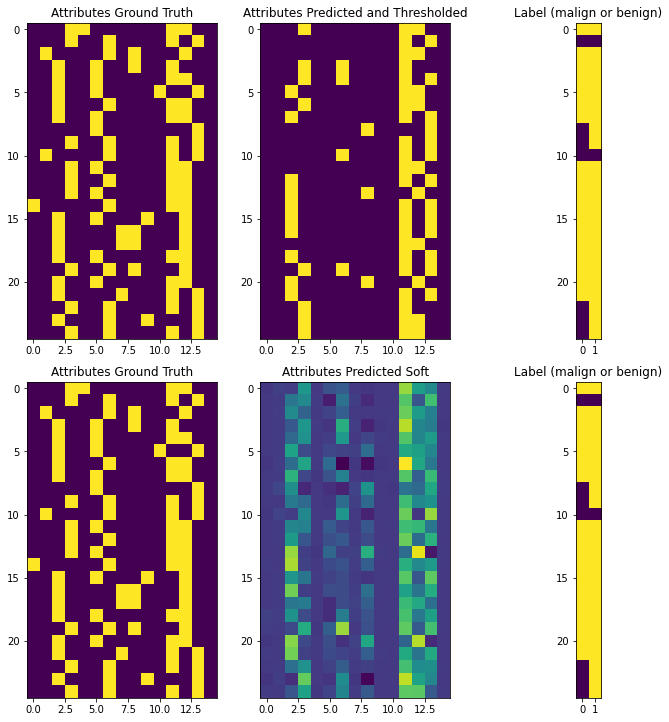

In [12]:
## ALL this should be on TEST set
# Visualizing the results for attributes and labels
attr_pred = np.squeeze(np.array(attr_pred))
attr_gt = np.squeeze(np.array(attr_gt))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(231)    # The big subplot
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


ax1.imshow(attr_gt)
ax1.set_title("Attributes Ground Truth")
ax2.imshow((attr_pred > 0.5) * 1)
ax2.set_title("Attributes Predicted and Thresholded")

ax3.imshow(viz)
ax3.set_title("Label (malign or benign)")

ax4.imshow(attr_gt)
ax4.set_title("Attributes Ground Truth")
ax5.imshow(attr_pred )
ax5.set_title("Attributes Predicted Soft")

ax6.imshow(viz)
ax6.set_title("Label (malign or benign)")


plt.tight_layout(pad=0.6, w_pad=0, h_pad=1.0)


Text(0.5, 0, 'Attribute probability')

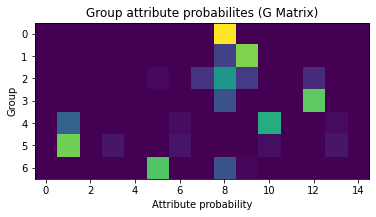

In [13]:
# Visualizing G matrix
plt.imshow(model.G_.data.detach().cpu().numpy())
plt.title("Group attribute probabilites (G Matrix)")
plt.ylabel("Group")
plt.xlabel("Attribute probability")

Text(0.5, 0, 'W values')

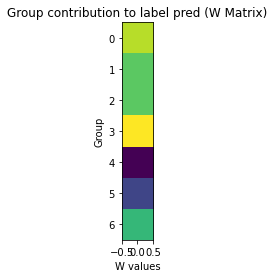

In [14]:
# Visualizing W Matrix
plt.imshow(model.W_.data.detach().cpu().numpy())
plt.title("Group contribution to label pred (W Matrix)")
plt.ylabel("Group")
plt.xlabel("W values")

In [93]:
# Legacy CAM code
# class CamExtractor():
#     """
#         Extracts cam features from the model
#     """
#     def __init__(self, model, target_layer):
#         self.model = model
#         self.target_layer = target_layer
        

#     def forward_pass_on_convolutions(self, x):
#         """
#             Does a forward pass on convolutions, hooks the function at given layer
#         """
#         conv_output = None
#         module_pos = 1
#         for module in self.model.features:
#             x = model.pool(module(x))  # Forward
#             if int(module_pos) == self.target_layer:
#                 conv_output = x  # Save the convolution output on that layer
#             module_pos += 1
#         return conv_output, x

#     def forward_pass(self, x):
#         """
#             Does a full forward pass on the model
#         """
#         conv_output, _ = self.forward_pass_on_convolutions(x)
#         x = F.interpolate(x, (300, 300), mode='bilinear')
#         (x_, _) = model(x)
#         return conv_output, x_

    
# extractor = CamExtractor(model, 4)

# count = 0
# for data in test_generator:
#     y_im_test = data["labels"][:, 15].to(device)
#     x_im_test = data["image"]
#     x_im_test = x_im_test.to(device)


#     [conv_out, x] = extractor.forward_pass_on_convolutions(x_im_test)
#     target = conv_out
#     cam = np.ones((target.shape[1:]), dtype=np.float32)
#     sal_map = np.zeros((224, 224))
#     for i in range(np.shape(target)[1]):
#                 # Unsqueeze to 4D
#                 saliency_map = torch.unsqueeze(torch.unsqueeze(target[0, i, :, :],0),0)
#                 # Upsampling to input size
#                 saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
#                 if saliency_map.max() == saliency_map.min():
#                     continue
#                 # Scale between 0-1
#                 norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
#                 inim = F.interpolate(x_im_test, size=(224, 224), mode='bilinear')
#                 w = extractor.forward_pass(inim * norm_saliency_map)[1]
#                 sal_map += w.cpu().data.numpy() * norm_saliency_map.cpu().data.numpy()[0, 0, :, :]
#                 cam += w.cpu().data.numpy() * target[0, i, :, :].cpu().data.numpy()


#     fig = plt.figure(figsize=(15, 10))

#     ax0 = fig.add_subplot(131)
#     ax0.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))

#     ax1 = fig.add_subplot(132)
#     ax1.imshow(sal_map)

#     ax2 = fig.add_subplot(133)
#     ax2.imshow(cam[0, :, :])
#     count += 1
#     if(count == 10):
#         break


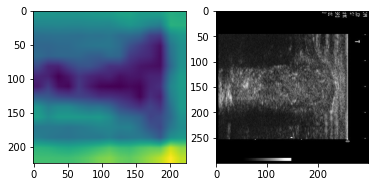

In [56]:
# Legacy CAM code
# fig = plt.figure()
# ax0 = fig.add_subplot(121)
# ax0.imshow(sal_map)

# ax1 = fig.add_subplot(122)
# ax1.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))



In [17]:
#Sankey plot code for G matrix
source = [i % a for i in range(z*a)]
target = [(i // 15) + 15 for i in range(z*a)]
G[G < 0.1] = 0.0
value = G.flatten().tolist()
#print(len(source), len(target), len(value))

color_node = [
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#FF0000', '#FFFF00', '#00FF00', '#00FFFF', '#FF00FF',
              '#00CED1', '#FF8C00', '#BDB76B', '#2F4F4F', '#B8860B'
              ]

color_link = []
link_colors = ['#F08080', '#FFFACD', '#98FB98', '#87CEFA', '#EE82EE',
              '#AFEEEE', '#FFA500', '#F0E68C', '#708090', '#DAA520']

In [18]:
for i in range(z):
    color_link.extend([link_colors[i]] * a)
#print(color_link)
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      color = color_node,
      label = ["cystic", "mostly solid", "solid", "spongiform",
               "hyper", "hypo", "iso", "marked",
               "ill-defined", "micro", "spiculated", "smooth",
               "macro", "micro", "non",
               "G1", "G2", "G3", "G4", "G5",
               "G6", "G7", "G8", "G9", "G10"],
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color_link
  ))])
fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()